# ***Guide on how to run the code***

## Run 'Import libraries', 'Import data', and 'Dataset characteristics, data imbalance, preview the images'. These are prerequisites to run the remaining two parts of the code.

# At this point, there are two paths to follow, each contains its own preprocessing steps:
## I. First model applying the original data splitting of Kaggle dataset

## II. Second set of models applying cross-validation with a hold-out test set - Model 2 to model 10



# **Import libraries**


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import seaborn as sns

# **Import data**


**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,856 X-Ray images in 2 categories (Pneumonia/Normal).**


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load datasets
train = get_training_data('/content/drive/MyDrive/Colab Notebooks_Deep learning/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/Colab Notebooks_Deep learning/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/Colab Notebooks_Deep learning/chest_xray/val')

100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


# **Dataset characteristics, data imbalance check, preview the images**

**Check the size of the training, test and validation datasets.**

There are 5216 images in the training set, 624 images in the test dataset, and 16 images in the validation dataset. They total to 5856.

In [ ]:
train.shape

(5216, 2)

In [ ]:
test.shape

(624, 2)

In [ ]:
val.shape

(16, 2)

**The dataset is imbalanced, the majority class (pneumonia) outweighs the minority class (normal).**

<Axes: xlabel='count'>

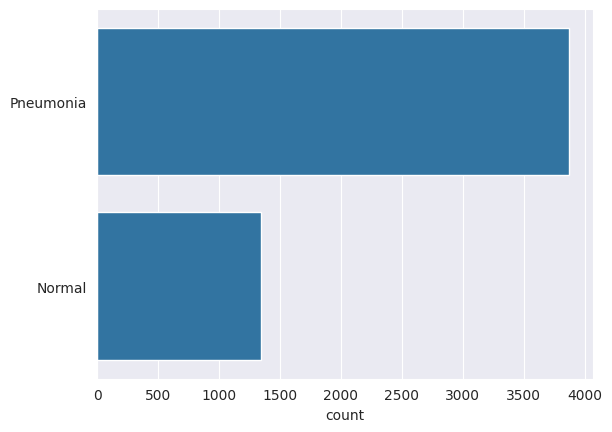

In [ ]:
# Visualise the imbalanced dataset

label = []
for i in train:
    if(i[1] == 0):
        label.append("Pneumonia")
    else:
        label.append("Normal")
sns.set_style('darkgrid')
sns.countplot(label)

**Preview the images of both classes.**

Text(0.5, 1.0, 'NORMAL')

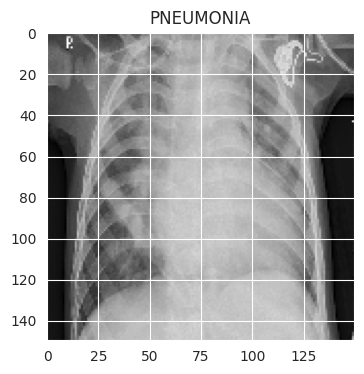

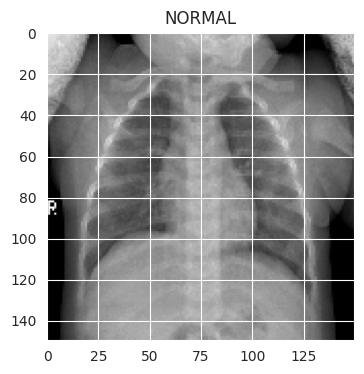

In [ ]:
plt.figure(figsize = (4,4))
plt.imshow(train[1][0], cmap='gray')
plt.title(labels[train[1][1]])

plt.figure(figsize = (4,4))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

# **I. First model applying the original data splitting - Model 1**

**The original splitting of dataset is applied ( (5216 images in the 'train' set, 624 images in the 'test' dataset, and 16 images in the 'validation dataset', totalling to 5856 images).**

#1. Model 1 - Preprocessing steps and train the model

1. **Without modifying the original splitting of the datasets** (5216 images in the training set, 624 images in the test dataset, and 16 images in the validation dataset, totalling to 5856 images).
2. **Data augmentation applied** to the training data.
3. Sequential CNN.
4. Image size 150X150.
4. Five convolutional layer with ReLU activation.
5. Drop-out, batch normalisation and max pooling downsampling technique is applied.
6. Optimiser RMSProp.


In [ ]:
# Splitting data into features and labels

X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for feature, label in train:
    X_train.append(feature)          #appending all images
    y_train.append(label)            #appending all labels

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [ ]:
# input normalisation

X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_val = np.array(X_val) / 255

In [ ]:
# resize data

X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
# Data augmentation to address overfitting

datagen1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen1.fit(X_train)

In [ ]:
# Train model_1a

model_1a = Sequential()
model_1a.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_1a.add(BatchNormalization())
model_1a.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1a.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1a.add(Dropout(0.1))
model_1a.add(BatchNormalization())
model_1a.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1a.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1a.add(BatchNormalization())
model_1a.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1a.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1a.add(Dropout(0.2))
model_1a.add(BatchNormalization())
model_1a.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1a.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1a.add(Dropout(0.2))
model_1a.add(BatchNormalization())
model_1a.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1a.add(Flatten())
model_1a.add(Dense(units = 128 , activation = 'relu'))
model_1a.add(Dropout(0.2))
model_1a.add(Dense(units = 1 , activation = 'sigmoid'))
model_1a.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_1a.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history_1a = model_1a.fit(datagen1.flow(X_train, y_train, batch_size = 32), epochs = 20, validation_data = (X_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.7789 - loss: 1.3473 - val_accuracy: 0.5000 - val_loss: 38.6141 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.8945 - loss: 0.2904 - val_accuracy: 0.5000 - val_loss: 56.5151 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8935 - loss: 0.2614
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8936 - loss: 0.2613 - val_accuracy: 0.5000 - val_loss: 13.5960 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9416 - loss: 0.1811 - val_accuracy: 0.8125 - val_loss: 0.4734 - learning_rate: 3.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9505 - loss: 0.1414 - val_accuracy: 0.8125 - val_loss: 0.4313 - learning_rate: 3.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9500 - loss: 0.1463


In [ ]:
print("Loss of the model_1a is - " , model_1a.evaluate(X_test,y_test)[0])
print("Accuracy of the model_1a is - " , model_1a.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 738ms/step - accuracy: 0.8990 - loss: 0.2551
Loss of the model_1a is -  0.2901015281677246
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.8990 - loss: 0.2551
Accuracy of the model_1a is -  89.42307829856873 %


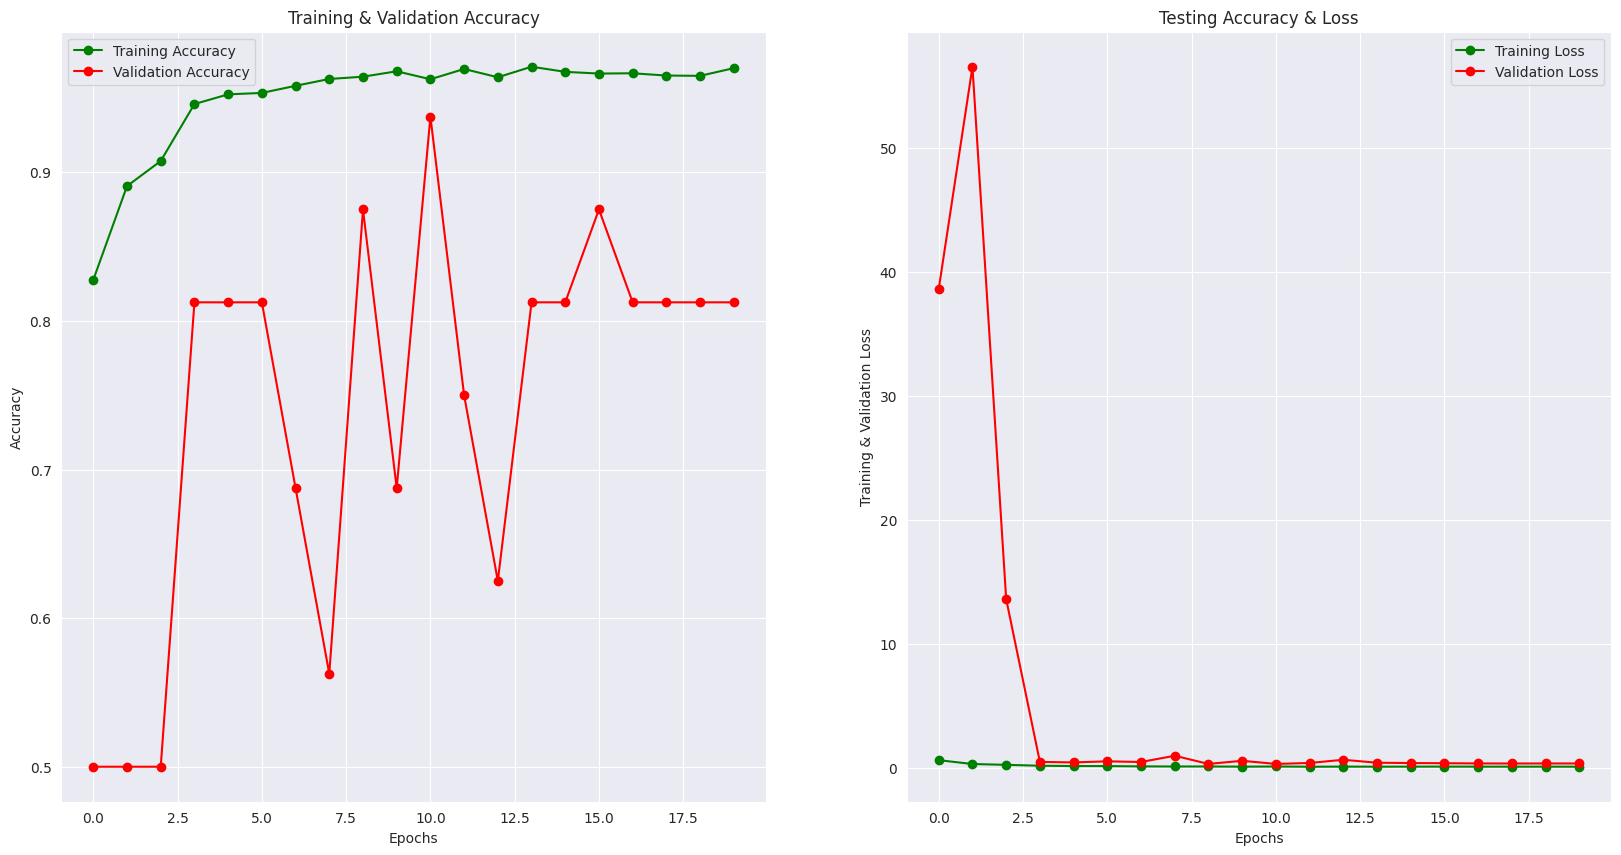

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history_1a.history['accuracy']
train_loss = history_1a.history['loss']
val_acc = history_1a.history['val_accuracy']
val_loss = history_1a.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions_1a = (model_1a.predict(X_test) > 0.5).astype("int32")
predictions_1a = predictions_1a.reshape(1,-1)[0]
predictions_1a[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_1a, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.90      0.91       390
   Normal (Class 1)       0.84      0.88      0.86       234

           accuracy                           0.89       624
          macro avg       0.89      0.89      0.89       624
       weighted avg       0.90      0.89      0.89       624



In [ ]:
cm_1a = confusion_matrix(y_test, predictions_1a)
cm_1a

array([[352,  38],
       [ 28, 206]])

In [ ]:
cm_1a = pd.DataFrame(cm_1a, index = ['0','1'] , columns = ['0','1'])

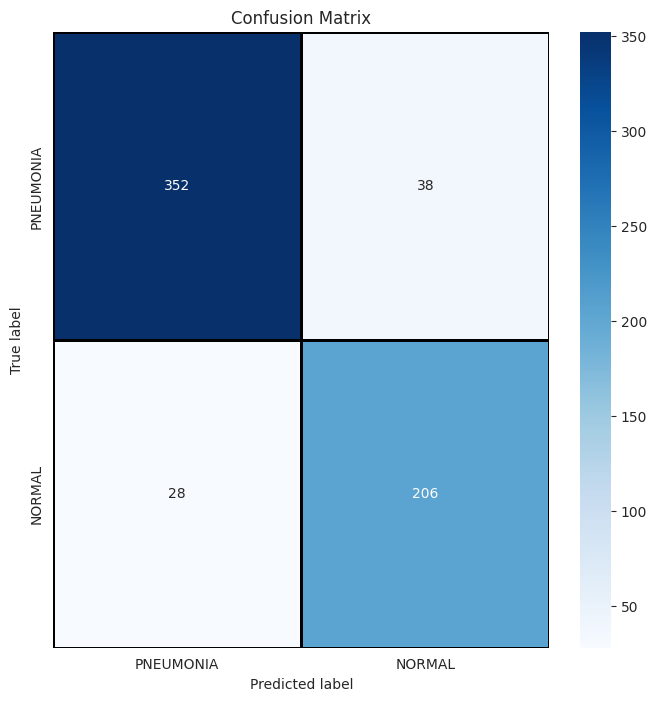

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(cm_1a,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

In [ ]:
# Train model_1b

model_1b = Sequential()
model_1b.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_1b.add(BatchNormalization())
model_1b.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1b.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1b.add(Dropout(0.1))
model_1b.add(BatchNormalization())
model_1b.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1b.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1b.add(BatchNormalization())
model_1b.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1b.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1b.add(Dropout(0.2))
model_1b.add(BatchNormalization())
model_1b.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1b.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_1b.add(Dropout(0.2))
model_1b.add(BatchNormalization())
model_1b.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1b.add(Flatten())
model_1b.add(Dense(units = 128 , activation = 'relu'))
model_1b.add(Dropout(0.2))
model_1b.add(Dense(units = 1 , activation = 'sigmoid'))
model_1b.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_1b.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history_1b = model_1b.fit(datagen1.flow(X_train, y_train, batch_size = 32), epochs = 20, validation_data = (X_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7871 - loss: 1.1972 - val_accuracy: 0.5000 - val_loss: 30.6876 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.8911 - loss: 0.2933 - val_accuracy: 0.5000 - val_loss: 53.7782 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9141 - loss: 0.2437
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9142 - loss: 0.2437 - val_accuracy: 0.5000 - val_loss: 20.7316 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9401 - loss: 0.1691 - val_accuracy: 0.5000 - val_loss: 19.9670 - learning_rate: 3.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9482 - loss: 0.1529
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9482 - loss: 

In [ ]:
print("Loss of the model_1b is - " , model_1b.evaluate(X_test,y_test)[0])
print("Accuracy of the model_1b is - " , model_1b.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.9005 - loss: 0.2231
Loss of the model_1b is -  0.24621592462062836
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.9005 - loss: 0.2231
Accuracy of the model_1b is -  89.42307829856873 %


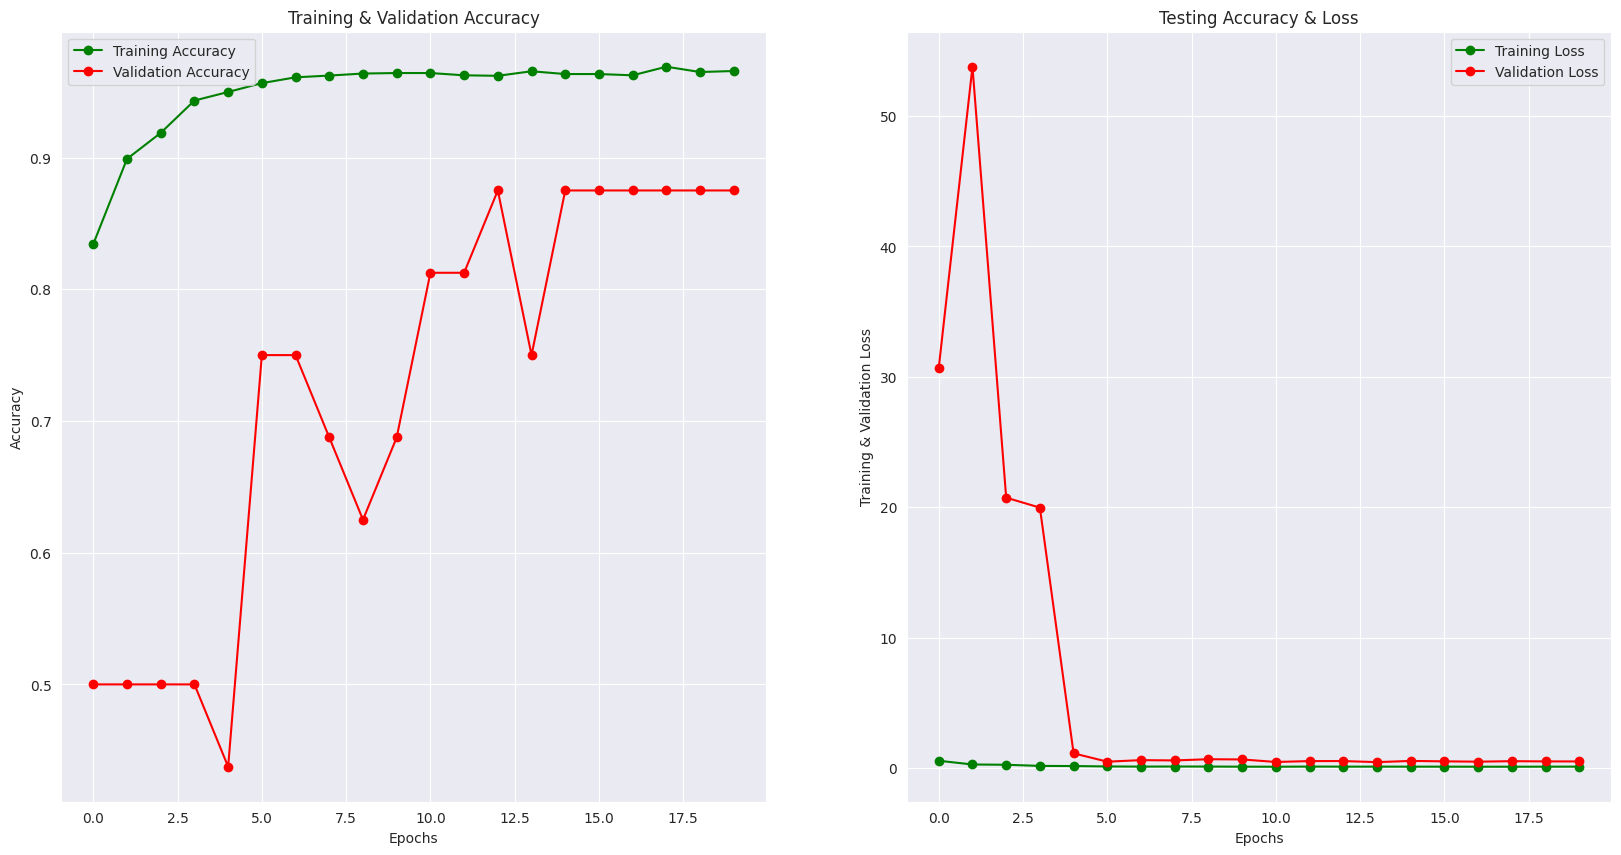

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history_1b.history['accuracy']
train_loss = history_1b.history['loss']
val_acc = history_1b.history['val_accuracy']
val_loss = history_1b.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions_1b = (model_1b.predict(X_test) > 0.5).astype("int32")
predictions_1b = predictions_1b.reshape(1,-1)[0]
predictions_1b[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_1b, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.89      0.91       390
   Normal (Class 1)       0.84      0.89      0.86       234

           accuracy                           0.89       624
          macro avg       0.88      0.89      0.89       624
       weighted avg       0.90      0.89      0.89       624



In [ ]:
cm_1b = confusion_matrix(y_test, predictions_1b)
cm_1b

array([[349,  41],
       [ 25, 209]])

In [ ]:
cm_1b = pd.DataFrame(cm_1b, index = ['0','1'] , columns = ['0','1'])

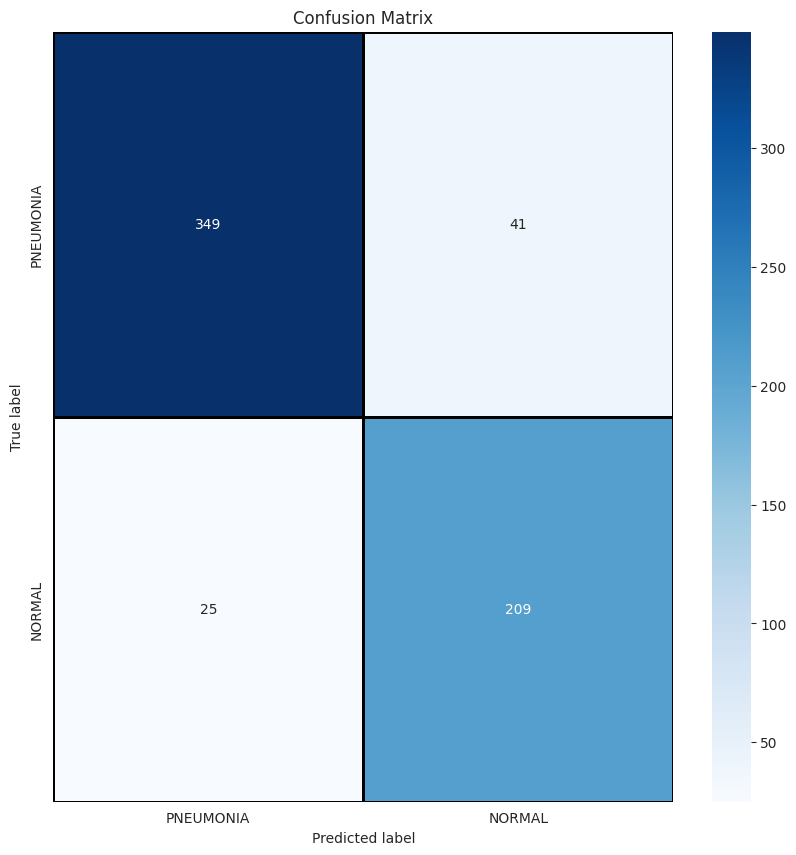

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_1b,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

# **II. Second set of models applying ross-validation with a hold-out test set - Model 2 to model 10**

1. **Re-splitting the dataset into 'train_val' and 'test' datasets (80% - 20%)**
2. **Applying k-fold cross validation to faciliate that the model generalizes well to unseen data by using different portions of the dataset for training and testing in multiple iterations.**



# Pre-processing steps - Re-splitting the dataset into 'train_val' and 'test' dataset

**Re-splitting the total dataset into 'train_val' and 'test' datasets, 80% and 20% respectively.**

In [ ]:
# Merge the three datasets (train, test and validation)
# Load the images from train, test and validation datasets into x and y variables

X = []
y = []

for feature, label in tqdm(train):
    X.append(feature)          #appending all images
    y.append(label)            #appending all labels

for feature, label in tqdm(test):
    X.append(feature)
    y.append(label)

for feature, label in tqdm(val):
    X.append(feature)
    y.append(label)

100%|██████████| 16/16 [00:00<00:00, 92309.30it/s]


In [ ]:
# Set image size

image_size = 150      #resize all images

In [ ]:
# Convert X to numpy array

X_new = np.array(X).reshape(-1, image_size, image_size, 1)

X_new.shape

(5856, 150, 150, 1)

In [ ]:
# Convert y to numpy array

y_new = np.array(y)
y_new = np.expand_dims(y_new, axis =1)
print(y_new)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [ ]:
y_new.shape

(5856, 1)

In [ ]:
# Split the dataset into train_val dataset and the test dataset, 80% and 20% respectively

X_train_val, X_test, y_train_val, y_test = train_test_split(X_new, y_new, test_size=0.20, random_state = 32)

**Check the size of train_val dataset.**
There are 4684 images in the train_val dataset.

In [ ]:
X_train_val.shape

(4684, 150, 150, 1)

In [ ]:
y_train_val.shape

(4684, 1)

**Check the size of test dataset.**
There are 1172 images in the test dataset.

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
y_test.shape

(1172, 1)

# Pre-processing steps - Input normalisation

**In our current dataset the pixel values range between 0 and 255, however, the neural networks prefer normalised datasets ranging between 0 and 1. Therfore, we normalise the input values.**

In [ ]:
# Normalise the input data

X_train_val = np.array(X_train_val) / 255
X_test = np.array(X_test) / 255
#X_val = np.array(X_val) / 255

In [ ]:
# Reshape the data to fit the model

X_train_val = X_train_val.reshape(-1, img_size, img_size, 1)
y_train_val = np.array(y_train_val)

#X_val = X_val.reshape(-1, img_size, img_size, 1)
#y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation


In order to prevent overfitting, we apply data augmentation to artificially expand the dataset by altering the training data with small transformations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques.
The following transformations will be applied to the training data:

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.

In [ ]:
# Data augmentation to prevent overfitting, applied to X_train_val dataset

datagen2 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen2.fit(X_train_val)

# Model 2

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Four convolutional layers** with ReLU activation.
6. **Without drop-out, batch normalisation.**
7. **Max pooling** downsampling technique is applied.
8. Optimiser **RMSProp**.
9. Three fold cross-validation used to validate the model, 20 epochs.
10. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
#model.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.1))
#model.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#model_2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Flatten())
model_2.add(Dense(units = 128 , activation = 'relu'))
#model.add(Dropout(0.2))
model_2.add(Dense(units = 1 , activation = 'sigmoid'))
model_2.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,768,257 (6.75 MB)

 Trainable params: 1,768,257 (6.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=20, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_2.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 3

#save the model history in a list after fitting so that we can plot later
model_history_2 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_2, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_2.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7254 - loss: 0.6533
Epoch 1: val_loss improved from inf to 0.48309, saving model to Pneumonia_2.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.7254 - loss: 0.6528 - val_accuracy: 0.7548 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7696 - loss: 0.4624
Epoch 2: val_loss improved from 0.48309 to 0.27581, saving model to Pneumonia_2.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.7697 - loss: 0.4623 - val_accuracy: 0.8742 - val_loss: 0.2758 - learning_rate: 0.0010
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8267 - loss: 0.3732
Epoch 3: val_loss did not improve from 0.27581
132/132 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.8268 - loss: 0.3731 - val_accuracy: 0.7889 - val_loss: 0.4109 - learning_rate: 0.0010
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8608 - loss: 0.3177
Epoch 4: val_loss improved fro

**Plots to see how the models are performing**

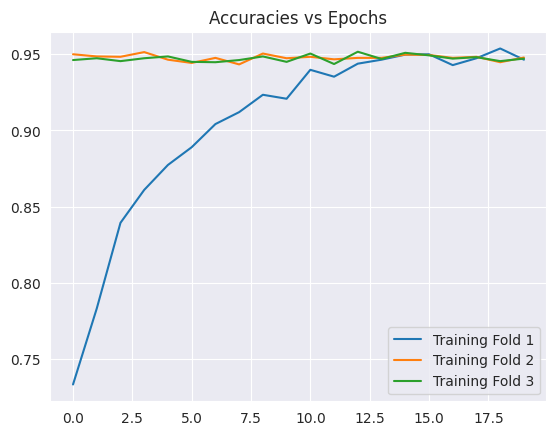

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_2[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_2[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history_2[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

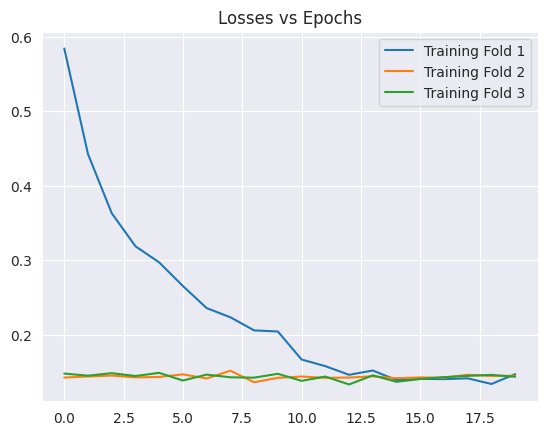

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_2[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_2[1].history['loss'], label='Training Fold 2')
plt.plot(model_history_2[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

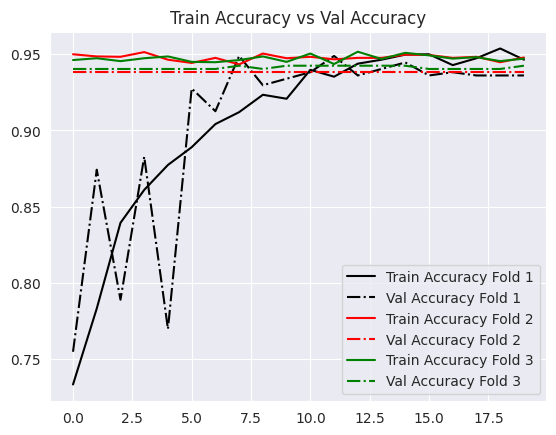

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_2[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_2[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_2[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_2[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history_2[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history_2[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

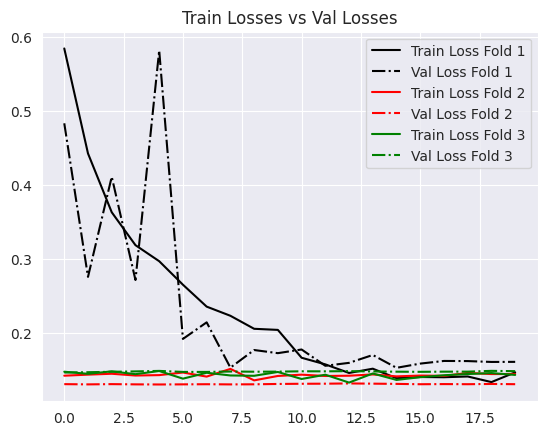

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_2[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_2[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_2[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_2[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history_2[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history_2[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_2 = load_model('Pneumonia_2.keras')

In [ ]:
print("Loss of the model_2 is - " , model_2.evaluate(X_test, y_test)[0])
print("Accuracy of the model_2 is - " , model_2.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 473ms/step - accuracy: 0.9479 - loss: 0.1396
Loss of the model_2 is -  0.1317363977432251
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 465ms/step - accuracy: 0.9479 - loss: 0.1396
Accuracy of the model_2 is -  94.7098970413208 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_2 = (model_2.predict(X_test) > 0.5).astype("int32")
predictions_2 = predictions_2.reshape(1,-1)[0]
predictions_2[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 477ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_2, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.98      0.95      0.96       843
   Normal (Class 1)       0.88      0.94      0.91       329

           accuracy                           0.95      1172
          macro avg       0.93      0.95      0.94      1172
       weighted avg       0.95      0.95      0.95      1172



In [ ]:
cm_2 = confusion_matrix(y_test,predictions_2)
cm_2

array([[800,  43],
       [ 19, 310]])

In [ ]:
cm_2 = pd.DataFrame(cm_2, index = ['0','1'] , columns = ['0','1'])

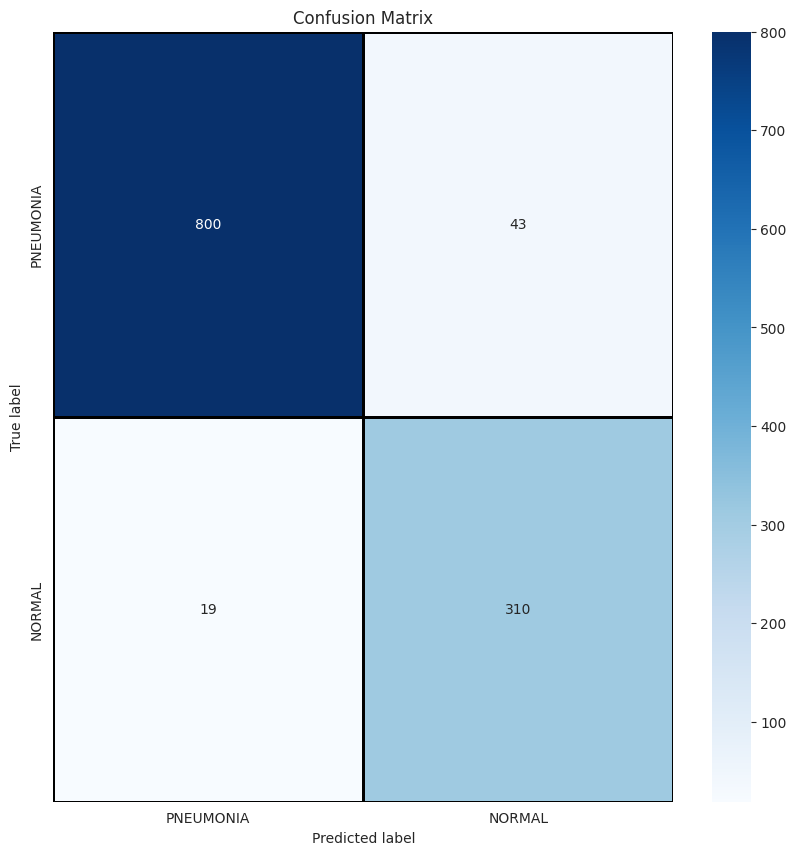

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_2,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_2.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_2 = []
incorrect_2 = []

for i in range(len(predictions_2)):
  if predictions_2[i] == y_test[i]:
    correct_2.append(i)
  else:
    incorrect_2.append(i)

**Display some of the correctly predicted classes**

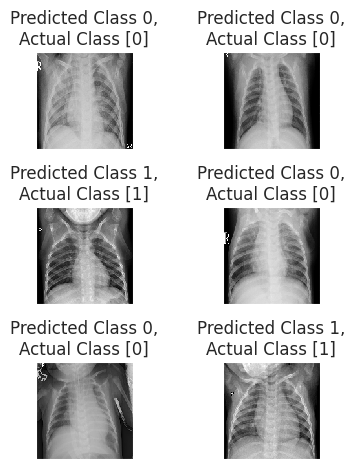

In [ ]:
i = 0
for c in correct_2[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_2[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

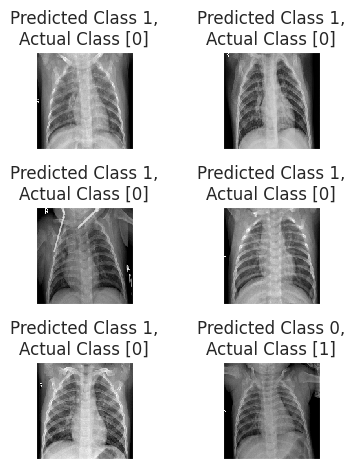

In [ ]:
i = 0
for c in incorrect_2[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_2[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 3

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Four convolutional layers** with ReLU activation.
6. **Drop-out, batch normalisation and max pooling** downsampling technique is applied.
7. Optimiser **RMSProp**.
8. Three fold cross-validation used to validate the model, 20 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.

In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(Dropout(0.1))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#model_3.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model_3.add(Dropout(0.2))
#model_3.add(BatchNormalization())
#model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Flatten())
model_3.add(Dense(units = 128 , activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(units = 1 , activation = 'sigmoid'))
model_3.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,769,409 (6.75 MB)

 Trainable params: 1,768,833 (6.75 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=20, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_3.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 3

#save the model history in a list after fitting so that we can plot later
model_history_3 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_3, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_3.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7505 - loss: 1.6360
Epoch 1: val_loss improved from inf to 4.99392, saving model to Pneumonia_3.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.7509 - loss: 1.6292 - val_accuracy: 0.7122 - val_loss: 4.9939 - learning_rate: 0.0010
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8679 - loss: 0.3515
Epoch 2: val_loss did not improve from 4.99392
132/132 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.8679 - loss: 0.3514 - val_accuracy: 0.7122 - val_loss: 15.4577 - learning_rate: 0.0010
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9024 - loss: 0.2711
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: val_loss did not improve from 4.99392
132/132 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.9023 - loss: 0.2711 - val_accuracy: 0.7122 - val_loss: 7.4564 - learning_rate: 0.0010
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9208 - loss

**Plots to see how the models are performing**

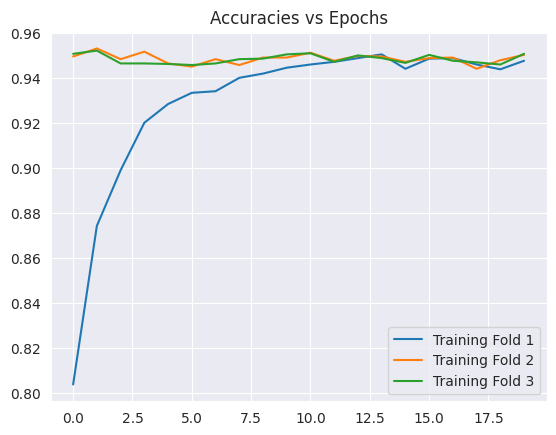

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_3[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_3[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history_3[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

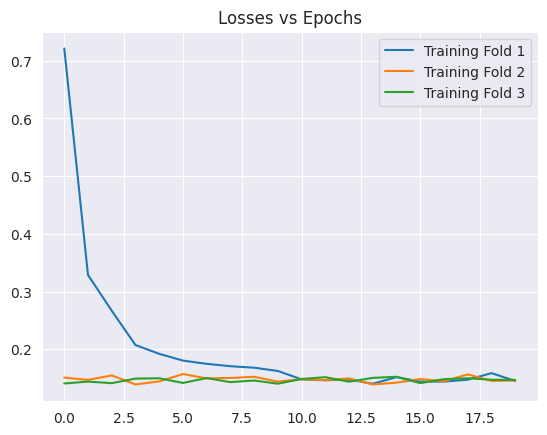

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_3[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_3[1].history['loss'], label='Training Fold 2')
plt.plot(model_history_3[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

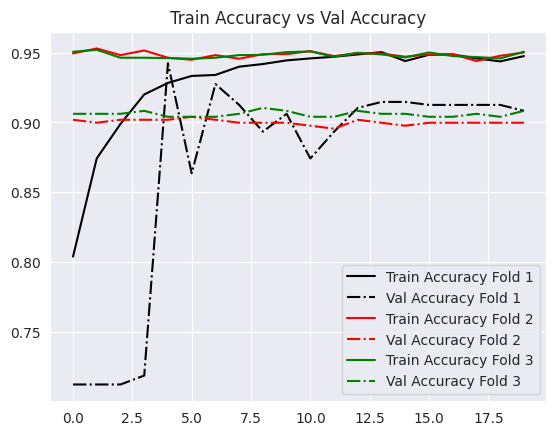

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_3[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_3[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_3[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_3[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history_3[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history_3[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

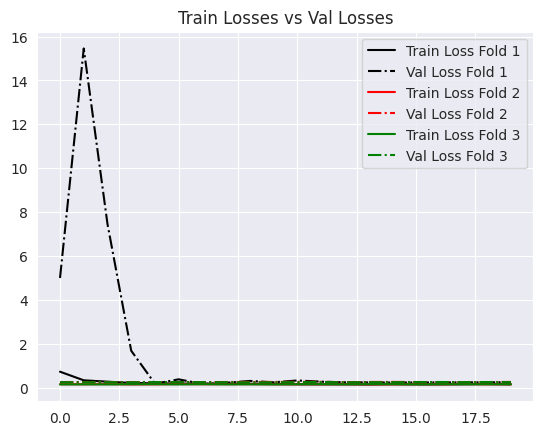

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_3[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_3[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_3[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_3[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history_3[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history_3[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**


In [ ]:
#Load the model that was saved by ModelCheckpoint

model_3 = load_model('Pneumonia_3.keras')

In [ ]:
print("Loss of the model_3 is - " , model_3.evaluate(X_test, y_test)[0])
print("Accuracy of the model_3 is - " , model_3.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.9061 - loss: 0.2275
Loss of the model_3 is -  0.22975844144821167
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.9061 - loss: 0.2275
Accuracy of the model_3 is -  89.93173837661743 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_3 = (model_3.predict(X_test) > 0.5).astype("int32")
predictions_3 = predictions_3.reshape(1,-1)[0]
predictions_3[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 702ms/step


array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_3, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.87      0.93       843
   Normal (Class 1)       0.75      0.97      0.84       329

           accuracy                           0.90      1172
          macro avg       0.87      0.92      0.88      1172
       weighted avg       0.92      0.90      0.90      1172



In [ ]:
cm_3 = confusion_matrix(y_test,predictions_3)
cm_3

array([[734, 109],
       [  9, 320]])

In [ ]:
cm_3 = pd.DataFrame(cm_3, index = ['0','1'] , columns = ['0','1'])

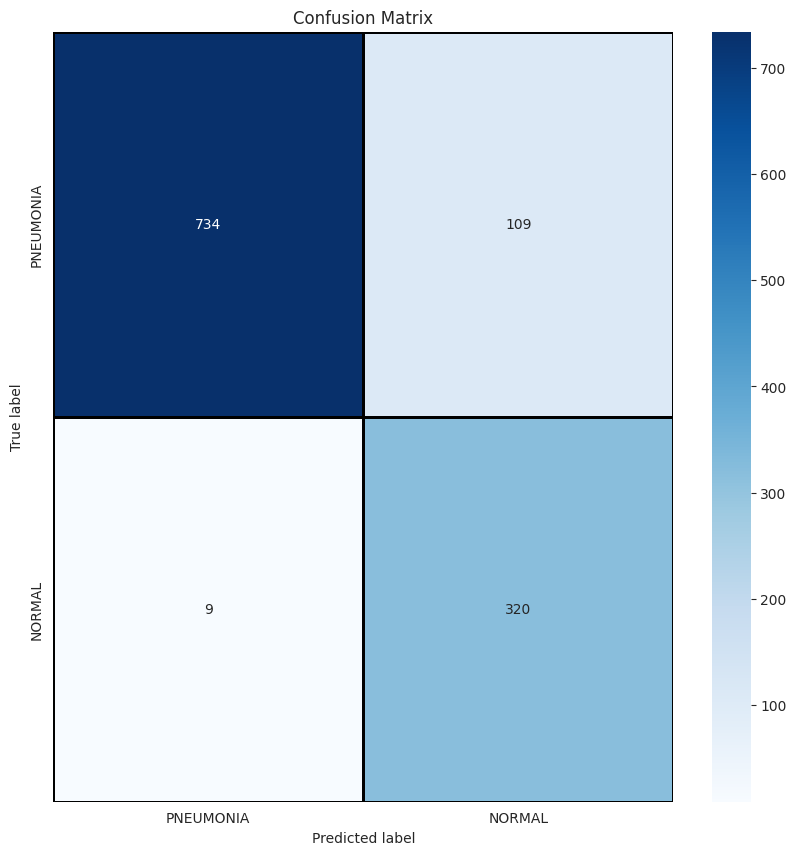

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_3,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_3.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_3 = []
incorrect_3 = []

for i in range(len(predictions_3)):
  if predictions_3[i] == y_test[i]:
    correct_3.append(i)
  else:
    incorrect_3.append(i)

In [ ]:
len(incorrect_3)

118

**Display some of the correctly predicted classes**

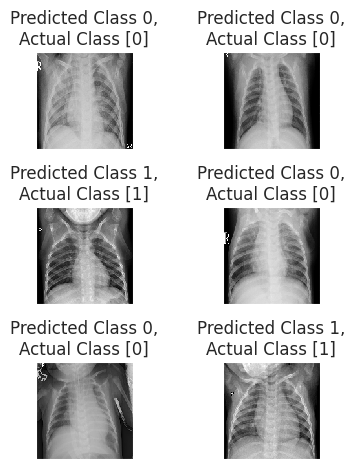

In [ ]:
i = 0
for c in correct_3[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_3[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

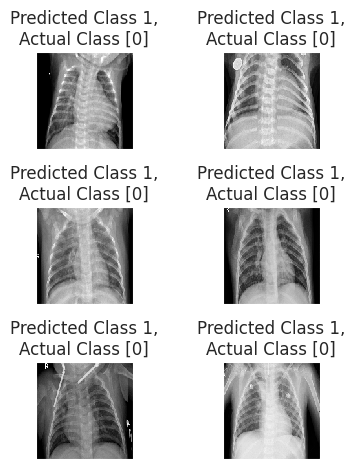

In [ ]:
i = 0
for c in incorrect_3[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_3[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 4

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Four convolutional layers** with ReLU activation.
6. Drop-out, batch normalisation and **average pooling** downsampling technique is applied.
7. Optimiser **RMSProp**.
8. Two fold cross-validation used to validate the model, 10 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.


In [ ]:
model_4 = Sequential()
model_4.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_4.add(BatchNormalization())
model_4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_4.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_4.add(Dropout(0.1))
model_4.add(BatchNormalization())
model_4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_4.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_4.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_4.add(Dropout(0.2))
model_4.add(BatchNormalization())
model_4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
#model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_4.add(Flatten())
model_4.add(Dense(units = 128 , activation = 'relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(units = 1 , activation = 'sigmoid'))
model_4.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 38, 38, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 19, 19, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 10, 10, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             1

 Total params: 1,769,409 (6.75 MB)

 Trainable params: 1,768,833 (6.75 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=10, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_4.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 2

#save the model history in a list after fitting so that we can plot later
model_history_4 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_4, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_4.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8091 - loss: 0.4751
Epoch 1: val_loss improved from inf to 1.00238, saving model to Pneumonia_4.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.8093 - loss: 0.4746 - val_accuracy: 0.2814 - val_loss: 1.0024 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8575 - loss: 0.3740
Epoch 2: val_loss did not improve from 1.00238
132/132 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.8576 - loss: 0.3736 - val_accuracy: 0.7420 - val_loss: 1.5437 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8930 - loss: 0.2831
Epoch 3: val_loss did not improve from 1.00238
132/132 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - accuracy: 0.8930 - loss: 0.2831 - val_accuracy: 0.7420 - val_loss: 4.6849 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9031 - loss: 0.2448
Epoch 4: ReduceLROnPlateau reducing l

**Plots to see how the models are performing.**

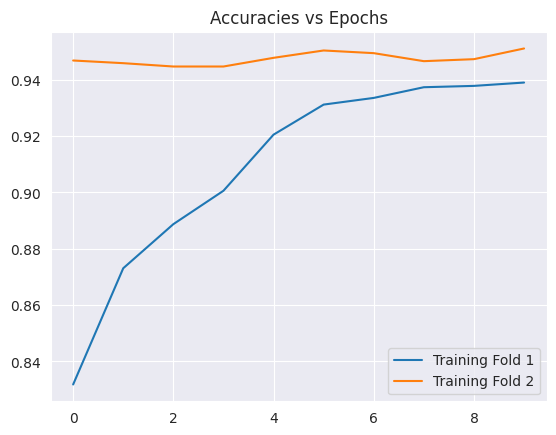

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_4[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_4[1].history['accuracy'], label='Training Fold 2')
#plt.plot(model_history_4[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

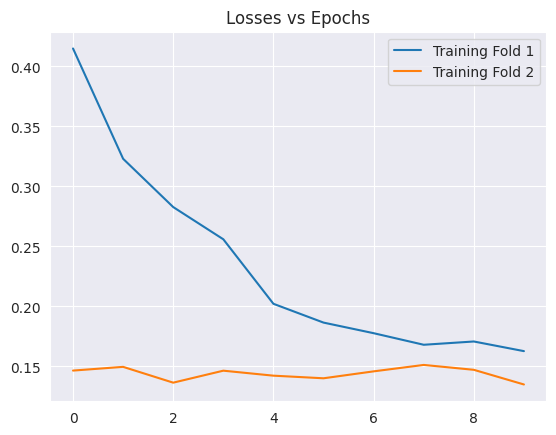

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_4[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_4[1].history['loss'], label='Training Fold 2')
#plt.plot(model_history_4[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

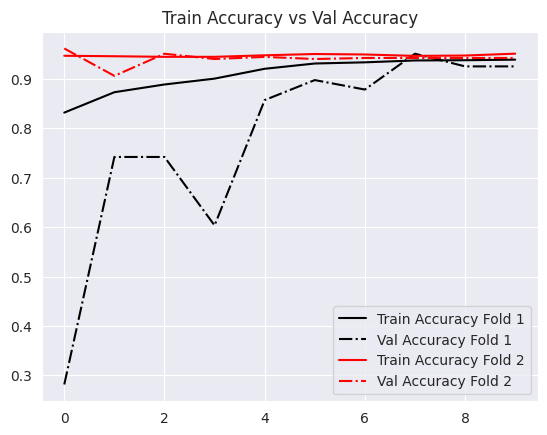

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_4[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_4[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_4[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_4[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_4[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history_4[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

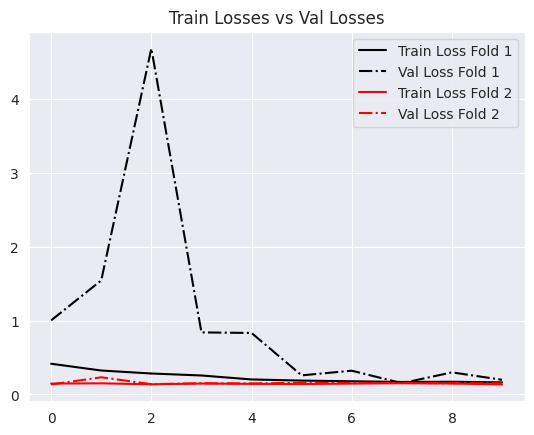

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_4[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_4[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_4[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_4[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_4[2].history['loss'], label='Train Loss Fold 3', color='green', )
#plt.plot(model_history_4[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_4 = load_model('Pneumonia_4.keras')

In [ ]:
print("Loss of the model_4 is - " , model_4.evaluate(X_test, y_test)[0])
print("Accuracy of the model_4 is - " , model_4.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step - accuracy: 0.9541 - loss: 0.1758
Loss of the model_4 is -  0.15603341162204742
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 580ms/step - accuracy: 0.9541 - loss: 0.1758
Accuracy of the model_4 is -  95.64846158027649 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_4 = (model_4.predict(X_test) > 0.5).astype("int32")
predictions_4 = predictions_4.reshape(1,-1)[0]
predictions_4[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_4, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.98      0.97       843
   Normal (Class 1)       0.94      0.90      0.92       329

           accuracy                           0.96      1172
          macro avg       0.95      0.94      0.95      1172
       weighted avg       0.96      0.96      0.96      1172



In [ ]:
cm_4 = confusion_matrix(y_test,predictions_4)
cm_4

array([[824,  19],
       [ 32, 297]])

In [ ]:
cm_4 = pd.DataFrame(cm_4, index = ['0','1'] , columns = ['0','1'])

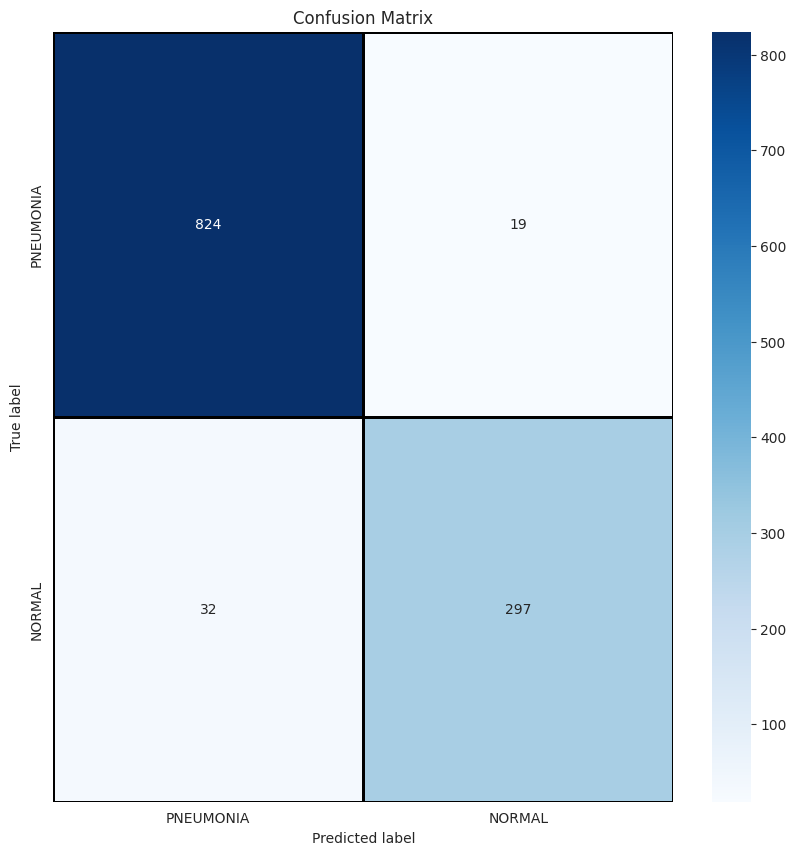

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_4,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_4.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_4 = []
incorrect_4 = []

for i in range(len(predictions_4)):
  if predictions_4[i] == y_test[i]:
    correct_4.append(i)
  else:
    incorrect_4.append(i)

**Display some of the correctly predicted classes**

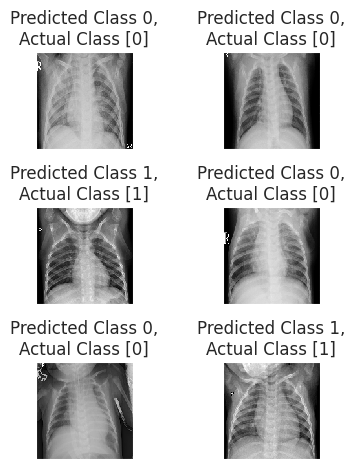

In [ ]:
i = 0
for c in correct_4[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_4[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

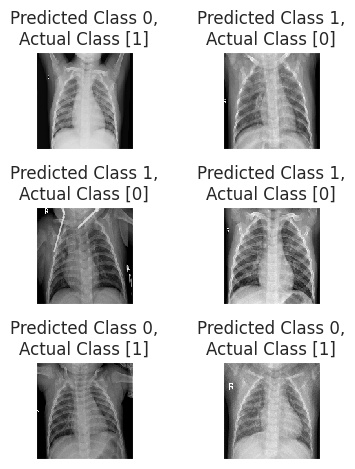

In [ ]:
i = 0
for c in incorrect_4[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_4[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 5

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Four convolutional layers** with ReLU activation.
6. Drop-out, batch normalisation and **max pooling** downsampling technique is applied.
7. Optimiser **Adam**.
8. Two fold cross-validation used to validate the model, 10 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.

In [ ]:
model_5 = Sequential()
model_5.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(Dropout(0.1))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(Flatten())
model_5.add(Dense(units = 128 , activation = 'relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(units = 1 , activation = 'sigmoid'))
model_5.compile(optimizer=Adam(learning_rate = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model_5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,769,409 (6.75 MB)

 Trainable params: 1,768,833 (6.75 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=10, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_5.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 2

#save the model history in a list after fitting so that we can plot later
model_history_5 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_5, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_5.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8353 - loss: 0.4026
Epoch 1: val_loss improved from inf to 1.87035, saving model to Pneumonia_5.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.8355 - loss: 0.4020 - val_accuracy: 0.7100 - val_loss: 1.8703 - learning_rate: 1.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8851 - loss: 0.2674
Epoch 2: val_loss did not improve from 1.87035
132/132 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.8852 - loss: 0.2672 - val_accuracy: 0.7100 - val_loss: 2.8301 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9077 - loss: 0.2346
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 3: val_loss did not improve from 1.87035
132/132 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.9077 - loss: 0.2346 - val_accuracy: 0.7100 - val_loss: 2.3239 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0

**Plots to see how the models are performing.**

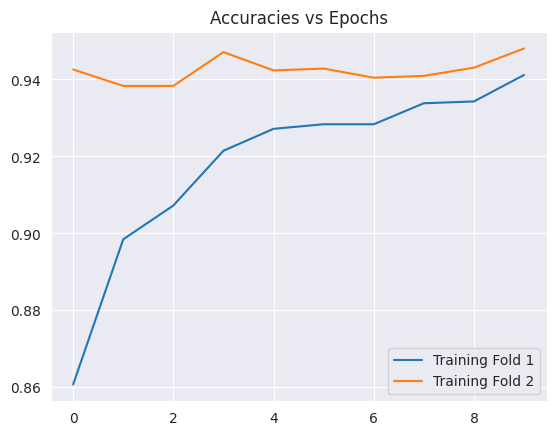

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_5[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_5[1].history['accuracy'], label='Training Fold 2')
#plt.plot(model_history_5[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

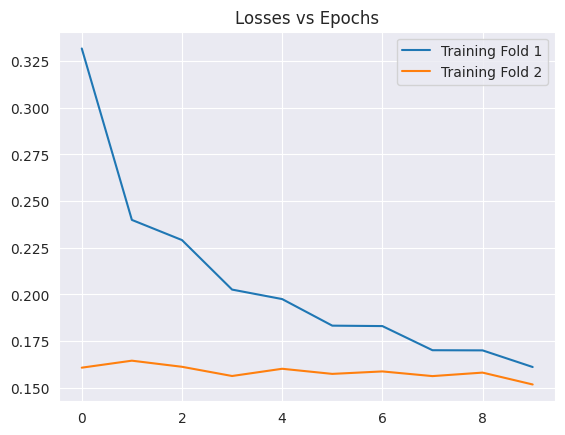

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_5[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_5[1].history['loss'], label='Training Fold 2')
#plt.plot(model_history_5[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

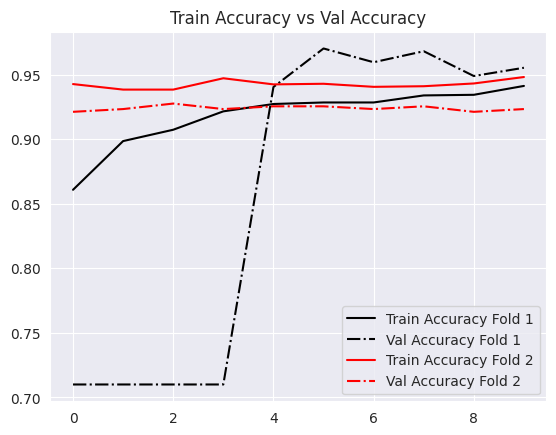

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_5[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_5[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_5[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_5[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_5[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history_5[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

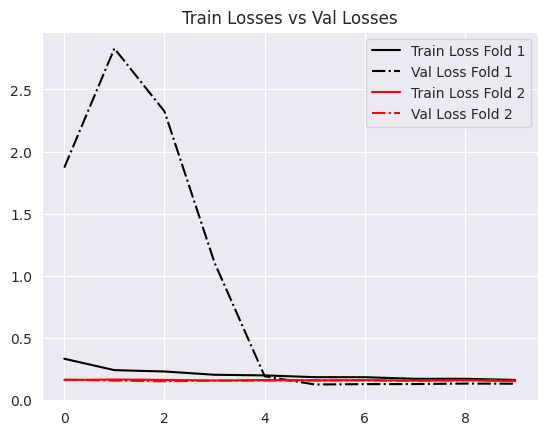

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_5[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_5[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_5[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_5[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_5[2].history['loss'], label='Train Loss Fold 3', color='green', )
#plt.plot(model_history_5[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_5 = load_model('Pneumonia_5.keras')

In [ ]:
print("Loss of the model_5 is - " , model_5.evaluate(X_test, y_test)[0])
print("Accuracy of the model_5 is - " , model_5.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.9335 - loss: 0.1657
Loss of the model_5 is -  0.15079522132873535
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 667ms/step - accuracy: 0.9335 - loss: 0.1657
Accuracy of the model_5 is -  93.94198060035706 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_5 = (model_5.predict(X_test) > 0.5).astype("int32")
predictions_5 = predictions_5.reshape(1,-1)[0]
predictions_5[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 568ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_5, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.94      0.96       843
   Normal (Class 1)       0.86      0.93      0.90       329

           accuracy                           0.94      1172
          macro avg       0.92      0.94      0.93      1172
       weighted avg       0.94      0.94      0.94      1172



In [ ]:
cm_5 = confusion_matrix(y_test,predictions_5)
cm_5

array([[795,  48],
       [ 23, 306]])

In [ ]:
cm_5 = pd.DataFrame(cm_5, index = ['0','1'] , columns = ['0','1'])

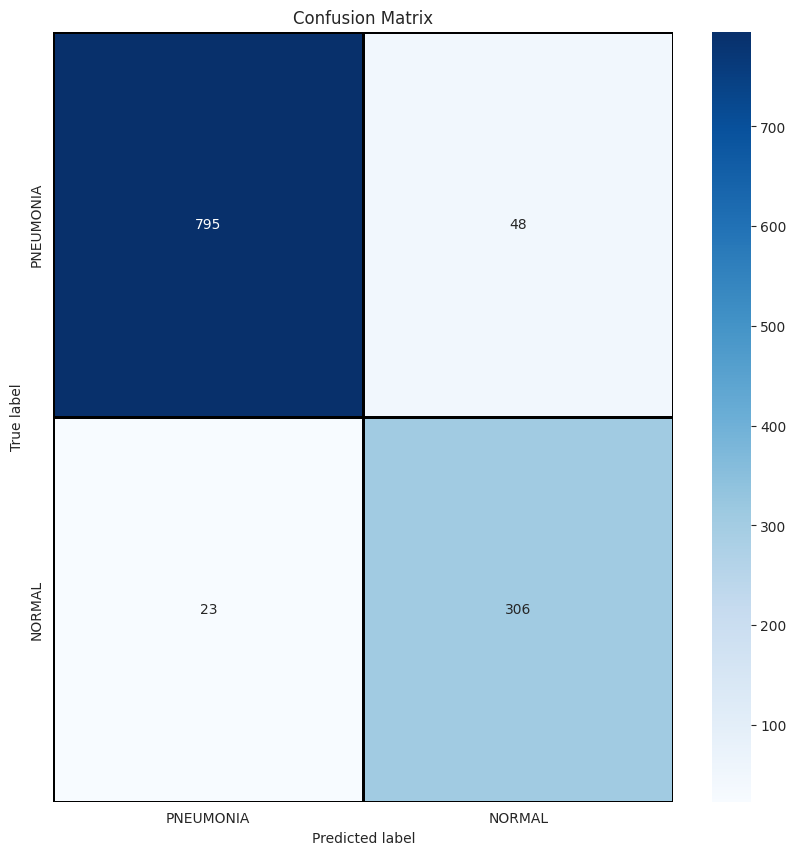

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_5,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_5.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_5 = []
incorrect_5 = []

for i in range(len(predictions_5)):
  if predictions_5[i] == y_test[i]:
    correct_5.append(i)
  else:
    incorrect_5.append(i)

**Display some of the correctly predicted classes**

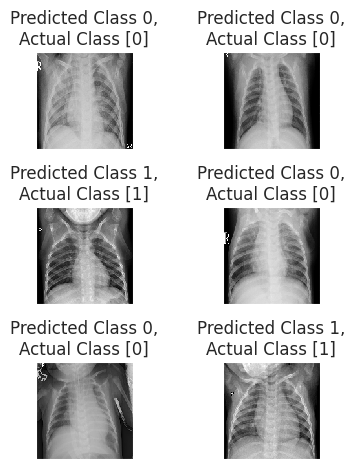

In [ ]:
i = 0
for c in correct_5[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_5[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

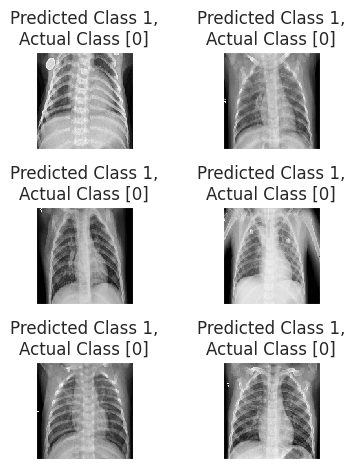

In [ ]:
i = 0
for c in incorrect_5[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_5[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 6

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Four convolutional layers** with ReLU activation.
6. Drop-out, batch normalisation and **average pooling** downsampling technique is applied.
7. Optimiser **Adam**.
8. Two fold cross-validation used to validate the model, 10 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.


In [ ]:
model_6 = Sequential()
model_6.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_6.add(BatchNormalization())
model_6.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_6.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_6.add(Dropout(0.1))
model_6.add(BatchNormalization())
model_6.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_6.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_6.add(BatchNormalization())
model_6.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_6.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_6.add(Dropout(0.2))
model_6.add(BatchNormalization())
model_6.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
#model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_6.add(Flatten())
model_6.add(Dense(units = 128 , activation = 'relu'))
model_6.add(Dropout(0.2))
model_6.add(Dense(units = 1 , activation = 'sigmoid'))
model_6.compile(optimizer=Adam(learning_rate = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model_6.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 75, 75, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 38, 38, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 19, 19, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 10, 10, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,769,409 (6.75 MB)

 Trainable params: 1,768,833 (6.75 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=10, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_6.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 2

#save the model history in a list after fitting so that we can plot later
model_history_6 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_6, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_6.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8258 - loss: 0.3852
Epoch 1: val_loss improved from inf to 0.66372, saving model to Pneumonia_6.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8261 - loss: 0.3846 - val_accuracy: 0.7249 - val_loss: 0.6637 - learning_rate: 1.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9061 - loss: 0.2455
Epoch 2: val_loss did not improve from 0.66372
132/132 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9061 - loss: 0.2454 - val_accuracy: 0.7249 - val_loss: 1.1229 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9088 - loss: 0.2298
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 3: val_loss did not improve from 0.66372
132/132 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9089 - loss: 0.2297 - val_accuracy: 0.7249 - val_loss: 0.9904 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0

**Plots to see how the models are performing.**

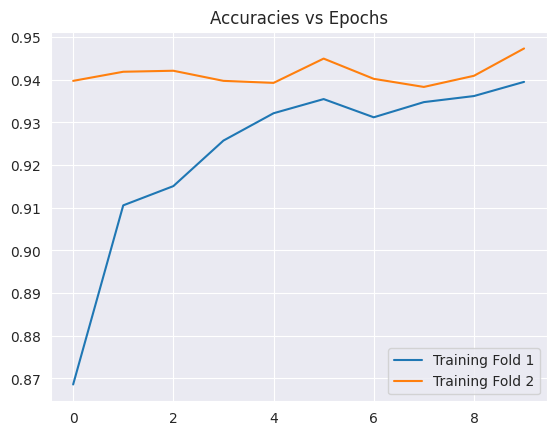

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_6[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_6[1].history['accuracy'], label='Training Fold 2')
#plt.plot(model_history_6[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

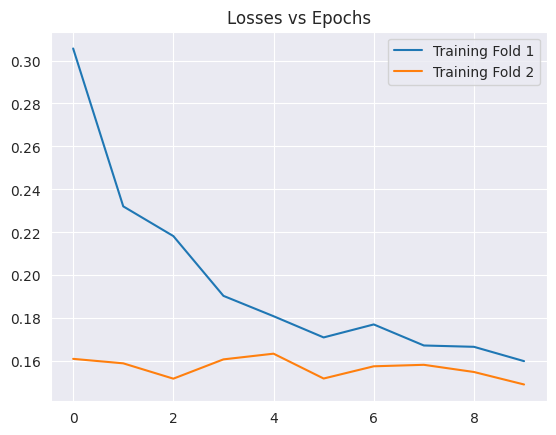

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_6[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_6[1].history['loss'], label='Training Fold 2')
#plt.plot(model_history_6[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

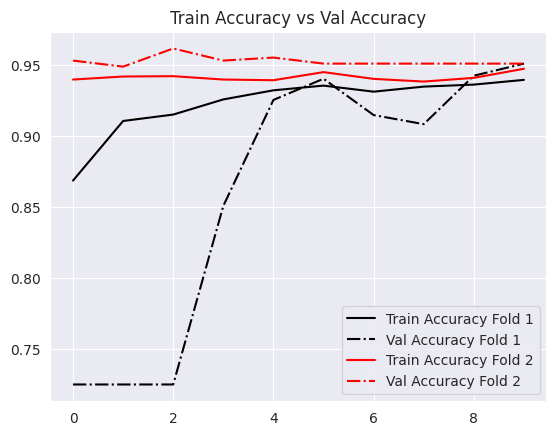

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_6[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_6[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_6[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_6[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_6[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history_6[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

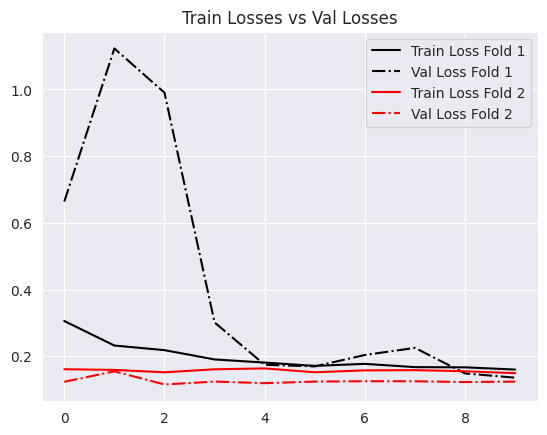

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_6[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_6[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_6[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_6[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_6[2].history['loss'], label='Train Loss Fold 3', color='green', )
#plt.plot(model_history_6[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_6 = load_model('Pneumonia_6.keras')

In [ ]:
print("Loss of the model_6 is - " , model_6.evaluate(X_test, y_test)[0])
print("Accuracy of the model_6 is - " , model_6.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step - accuracy: 0.9401 - loss: 0.1543
Loss of the model_6 is -  0.14459452033042908
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.9401 - loss: 0.1543
Accuracy of the model_6 is -  94.02730464935303 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_6 = (model_6.predict(X_test) > 0.5).astype("int32")
predictions_6 = predictions_6.reshape(1,-1)[0]
predictions_6[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_6, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.95      0.96       843
   Normal (Class 1)       0.89      0.90      0.89       329

           accuracy                           0.94      1172
          macro avg       0.92      0.93      0.93      1172
       weighted avg       0.94      0.94      0.94      1172



In [ ]:
cm_6 = confusion_matrix(y_test,predictions_6)
cm_6

array([[805,  38],
       [ 32, 297]])

In [ ]:
cm_6 = pd.DataFrame(cm_6, index = ['0','1'] , columns = ['0','1'])

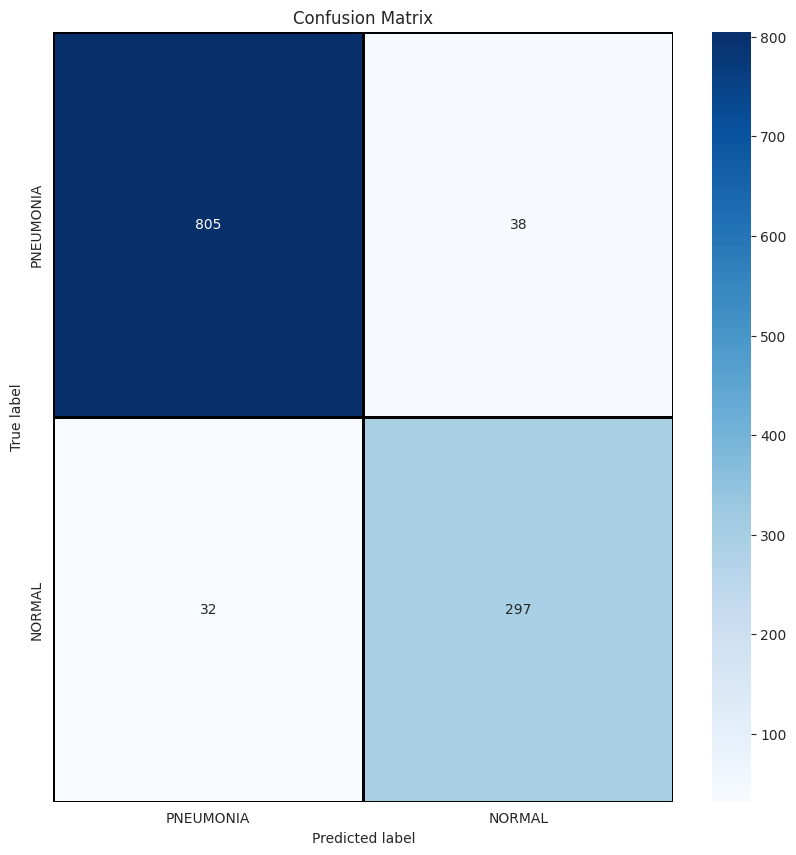

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_6,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_6.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_6 = []
incorrect_6 = []

for i in range(len(predictions_6)):
  if predictions_6[i] == y_test[i]:
    correct_6.append(i)
  else:
    incorrect_6.append(i)

**Display some of the correctly predicted classes**

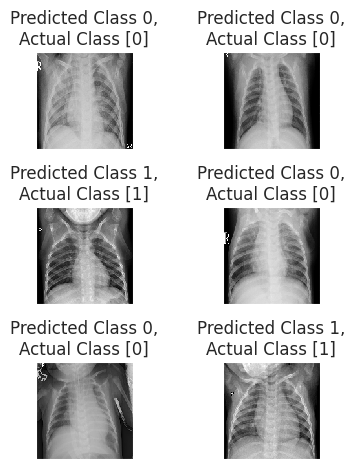

In [ ]:
i = 0
for c in correct_6[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_6[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

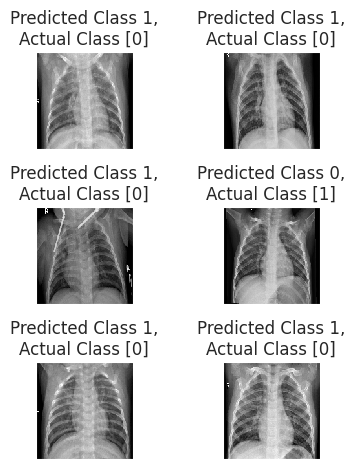

In [ ]:
i = 0
for c in incorrect_6[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_6[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 7

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Five convolutional layers** with ReLU activation.
6. Drop-out, batch normalisation and **max pooling** downsampling technique is applied.
7. Optimiser **RMSProp**.
8. Two fold cross-validation used to validate the model, 10 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.

In [ ]:
model_7 = Sequential()
model_7.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_7.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_7.add(Dropout(0.1))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_7.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_7.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_7.add(Dropout(0.2))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_7.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_7.add(Dropout(0.2))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_7.add(Flatten())
model_7.add(Dense(units = 128 , activation = 'relu'))
model_7.add(Dropout(0.2))
model_7.add(Dense(units = 1 , activation = 'sigmoid'))
model_7.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_7.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=10, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_7.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 2

#save the model history in a list after fitting so that we can plot later
model_history_7 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_7, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_7.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7543 - loss: 1.3888
Epoch 1: val_loss improved from inf to 10.15797, saving model to Pneumonia_7.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.7546 - loss: 1.3833 - val_accuracy: 0.7335 - val_loss: 10.1580 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8772 - loss: 0.3022
Epoch 2: val_loss improved from 10.15797 to 9.78263, saving model to Pneumonia_7.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - accuracy: 0.8772 - loss: 0.3022 - val_accuracy: 0.7335 - val_loss: 9.7826 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8949 - loss: 0.2693
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: val_loss did not improve from 9.78263
132/132 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.8949 - loss: 0.2693 - val_accuracy: 0.7335 - val_loss: 11.8515 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━

**Plots to see how the models are performing.**

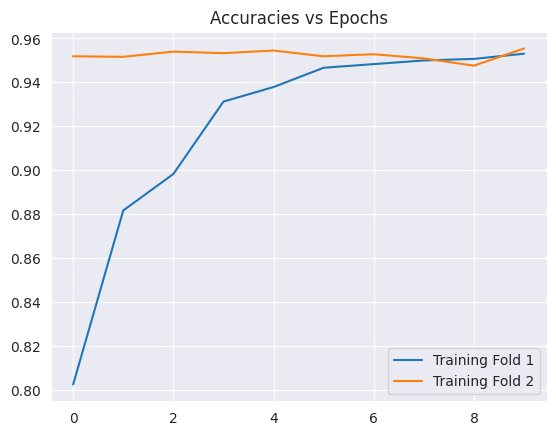

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_7[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_7[1].history['accuracy'], label='Training Fold 2')
#plt.plot(model_history_7[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

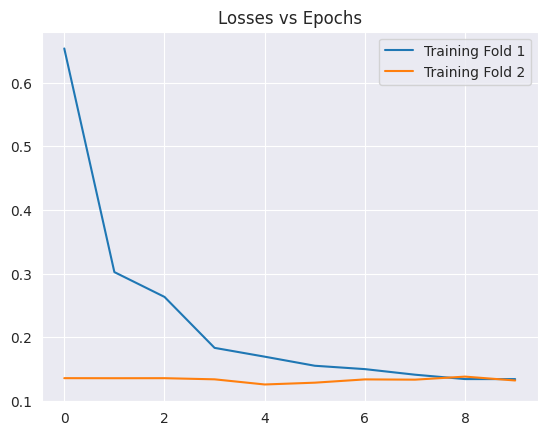

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_7[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_7[1].history['loss'], label='Training Fold 2')
#plt.plot(model_history_7[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

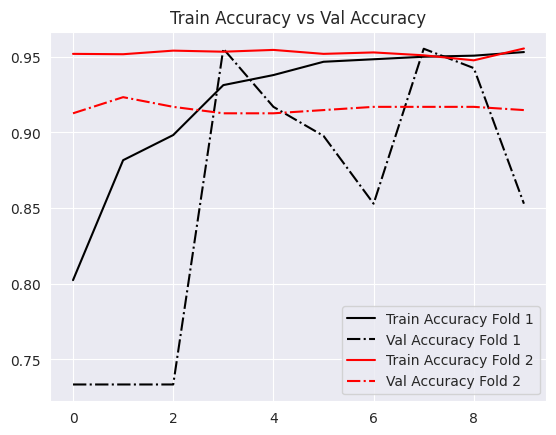

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_7[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_7[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_7[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_7[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_7[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history_7[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

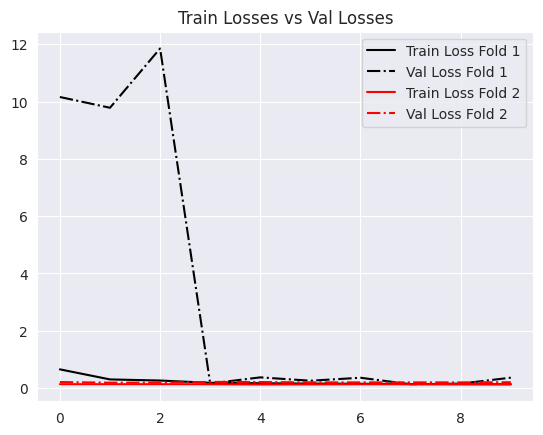

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_7[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_7[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_7[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_7[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_7[2].history['loss'], label='Train Loss Fold 3', color='green', )
#plt.plot(model_history_7[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_7 = load_model('Pneumonia_7.keras')

In [ ]:
print("Loss of the model_7 is - " , model_7.evaluate(X_test, y_test)[0])
print("Accuracy of the model_7 is - " , model_7.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 732ms/step - accuracy: 0.9273 - loss: 0.2002
Loss of the model_7 is -  0.19691236317157745
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 583ms/step - accuracy: 0.9273 - loss: 0.2002
Accuracy of the model_7 is -  92.0648455619812 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_7 = (model_7.predict(X_test) > 0.5).astype("int32")
predictions_7 = predictions_7.reshape(1,-1)[0]
predictions_7[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 699ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_7, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.98      0.90      0.94       843
   Normal (Class 1)       0.80      0.96      0.87       329

           accuracy                           0.92      1172
          macro avg       0.89      0.93      0.91      1172
       weighted avg       0.93      0.92      0.92      1172



In [ ]:
cm_7 = confusion_matrix(y_test,predictions_7)
cm_7

array([[762,  81],
       [ 12, 317]])

In [ ]:
cm_7 = pd.DataFrame(cm_7, index = ['0','1'] , columns = ['0','1'])

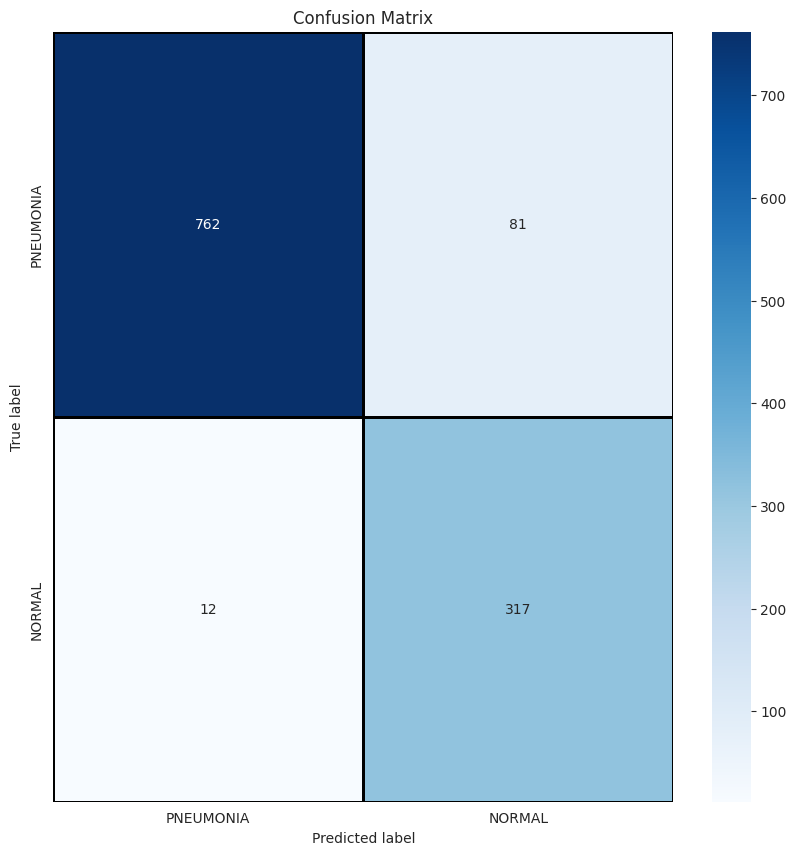

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_7,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_7.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_7 = []
incorrect_7 = []

for i in range(len(predictions_7)):
  if predictions_7[i] == y_test[i]:
    correct_7.append(i)
  else:
    incorrect_7.append(i)

**Display some of the correctly predicted classes**

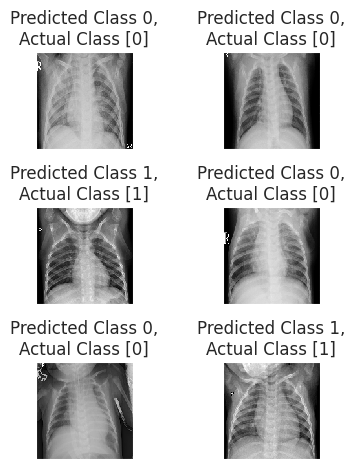

In [ ]:
i = 0
for c in correct_7[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_7[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

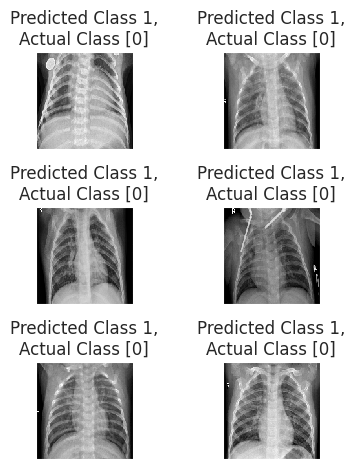

In [ ]:
i = 0
for c in incorrect_7[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_7[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 8

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Five convolutional layers** with ReLU activation.
6. Drop-out, batch normalisation and **average pooling** downsampling technique is applied.
7. Optimiser **RMSProp**.
8. Two fold cross-validation used to validate the model, 10 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.

In [ ]:
model_8 = Sequential()
model_8.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_8.add(BatchNormalization())
model_8.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_8.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_8.add(Dropout(0.1))
model_8.add(BatchNormalization())
model_8.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_8.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_8.add(BatchNormalization())
model_8.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_8.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_8.add(Dropout(0.2))
model_8.add(BatchNormalization())
model_8.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_8.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_8.add(Dropout(0.2))
model_8.add(BatchNormalization())
model_8.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_8.add(Flatten())
model_8.add(Dense(units = 128 , activation = 'relu'))
model_8.add(Dropout(0.2))
model_8.add(Dense(units = 1 , activation = 'sigmoid'))
model_8.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_8.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 38, 38, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 19, 19, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 10, 10, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=10, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_8.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 2

#save the model history in a list after fitting so that we can plot later
model_history_8 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_8, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_8.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7681 - loss: 0.7314
Epoch 1: val_loss improved from inf to 1.58650, saving model to Pneumonia_8.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.7685 - loss: 0.7295 - val_accuracy: 0.3518 - val_loss: 1.5865 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8595 - loss: 0.3050
Epoch 2: val_loss did not improve from 1.58650
132/132 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.8596 - loss: 0.3049 - val_accuracy: 0.7313 - val_loss: 3.3463 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8912 - loss: 0.2660
Epoch 3: val_loss did not improve from 1.58650
132/132 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.8912 - loss: 0.2659 - val_accuracy: 0.3795 - val_loss: 4.2985 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9077 - loss: 0.2375
Epoch 4: val_loss improved from 1.58650 to 0.77891, saving model to P

**Plots to see how the models are performing.**

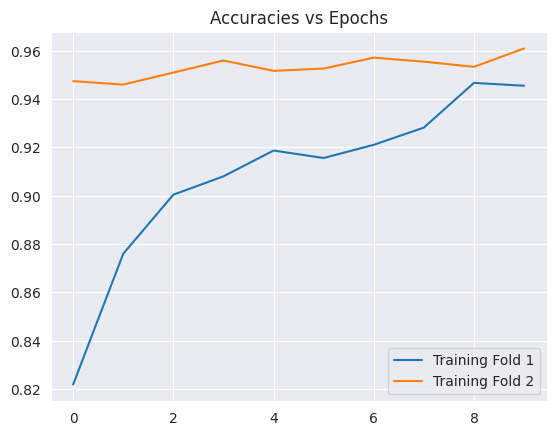

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_8[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_8[1].history['accuracy'], label='Training Fold 2')
#plt.plot(model_history_8[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

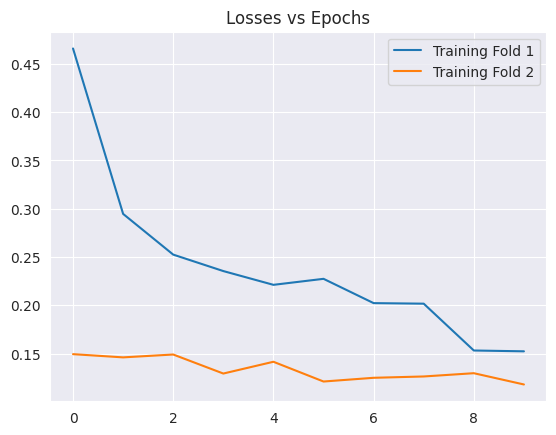

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_8[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_8[1].history['loss'], label='Training Fold 2')
#plt.plot(model_history_8[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

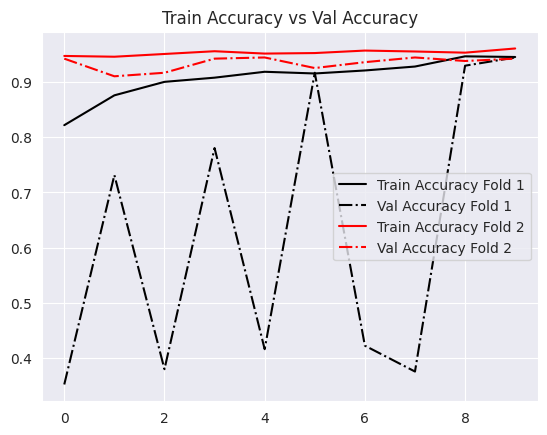

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_8[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_8[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_8[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_8[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_8[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history_8[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

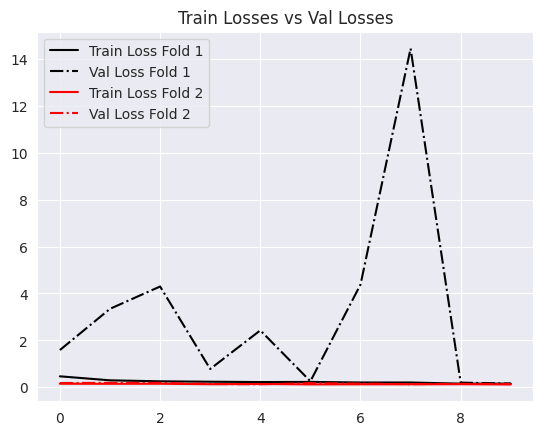

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_8[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_8[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_8[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_8[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_8[2].history['loss'], label='Train Loss Fold 3', color='green', )
#plt.plot(model_history_8[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_8 = load_model('Pneumonia_8.keras')

In [ ]:
print("Loss of the model_8 is - " , model_8.evaluate(X_test, y_test)[0])
print("Accuracy of the model_8 is - " , model_8.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 622ms/step - accuracy: 0.9528 - loss: 0.1270
Loss of the model_8 is -  0.1250305324792862
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 566ms/step - accuracy: 0.9528 - loss: 0.1270
Accuracy of the model_8 is -  95.13651728630066 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_8 = (model_8.predict(X_test) > 0.5).astype("int32")
predictions_8 = predictions_8.reshape(1,-1)[0]
predictions_8[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 671ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_8, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.97      0.97       843
   Normal (Class 1)       0.91      0.91      0.91       329

           accuracy                           0.95      1172
          macro avg       0.94      0.94      0.94      1172
       weighted avg       0.95      0.95      0.95      1172



In [ ]:
cm_8 = confusion_matrix(y_test,predictions_8)
cm_8

array([[814,  29],
       [ 28, 301]])

In [ ]:
cm_8 = pd.DataFrame(cm_8, index = ['0','1'] , columns = ['0','1'])

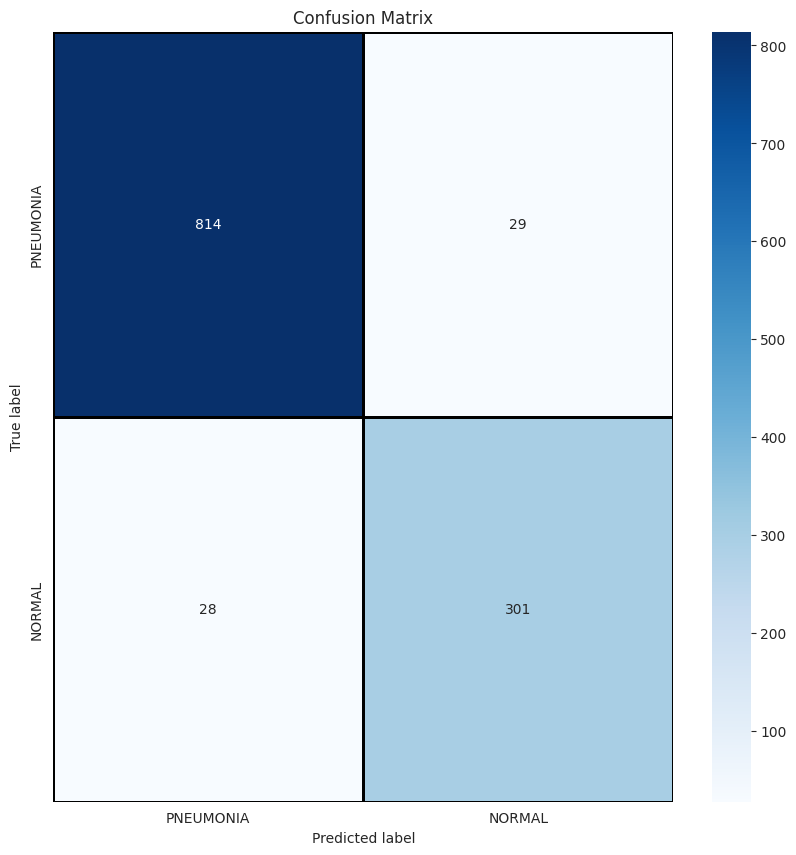

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_8,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_8.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_8 = []
incorrect_8 = []

for i in range(len(predictions_8)):
  if predictions_8[i] == y_test[i]:
    correct_8.append(i)
  else:
    incorrect_8.append(i)

**Display some of the correctly predicted classes**

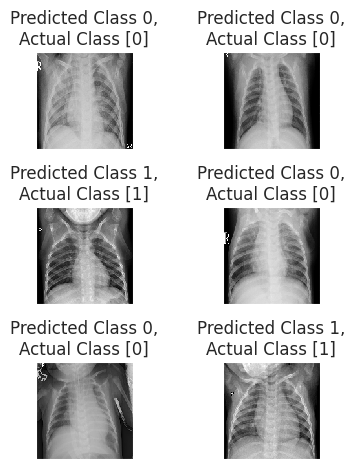

In [ ]:
i = 0
for c in correct_8[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_8[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

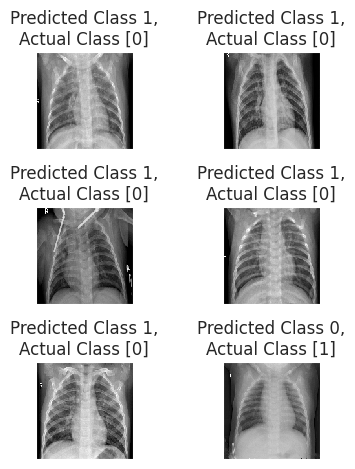

In [ ]:
i = 0
for c in incorrect_8[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_8[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 9

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Five convolutional layers** with ReLU activation.
6. Drop-out, batch normalisation and **max pooling** downsampling technique is applied.
7. Optimiser **Adam**.
8. Two fold cross-validation used to validate the model, 10 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.

In [ ]:
model_9 = Sequential()
model_9.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_9.add(BatchNormalization())
model_9.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_9.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_9.add(Dropout(0.1))
model_9.add(BatchNormalization())
model_9.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_9.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_9.add(BatchNormalization())
model_9.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_9.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_9.add(Dropout(0.2))
model_9.add(BatchNormalization())
model_9.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_9.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_9.add(Dropout(0.2))
model_9.add(BatchNormalization())
model_9.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_9.add(Flatten())
model_9.add(Dense(units = 128 , activation = 'relu'))
model_9.add(Dropout(0.2))
model_9.add(Dense(units = 1 , activation = 'sigmoid'))
model_9.compile(optimizer=Adam(learning_rate = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model_9.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=10, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_9.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 2

#save the model history in a list after fitting so that we can plot later
model_history_9 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_9, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_9.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7975 - loss: 0.5359
Epoch 1: val_loss improved from inf to 1.71176, saving model to Pneumonia_9.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.7979 - loss: 0.5347 - val_accuracy: 0.7484 - val_loss: 1.7118 - learning_rate: 1.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8879 - loss: 0.2553
Epoch 2: val_loss did not improve from 1.71176
132/132 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.8880 - loss: 0.2551 - val_accuracy: 0.7484 - val_loss: 3.0838 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9171 - loss: 0.2187
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 3: val_loss did not improve from 1.71176
132/132 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.9171 - loss: 0.2187 - val_accuracy: 0.7484 - val_loss: 2.4084 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0

**Plots to see how the models are performing.**

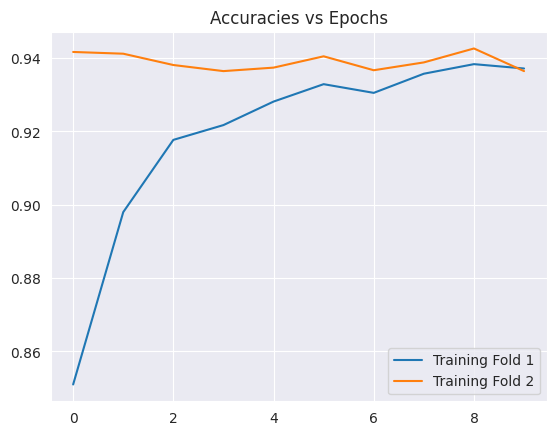

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_9[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_9[1].history['accuracy'], label='Training Fold 2')
#plt.plot(model_history_9[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

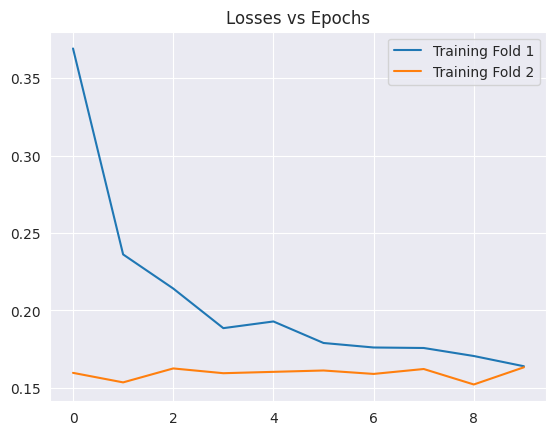

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_9[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_9[1].history['loss'], label='Training Fold 2')
#plt.plot(model_history_9[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

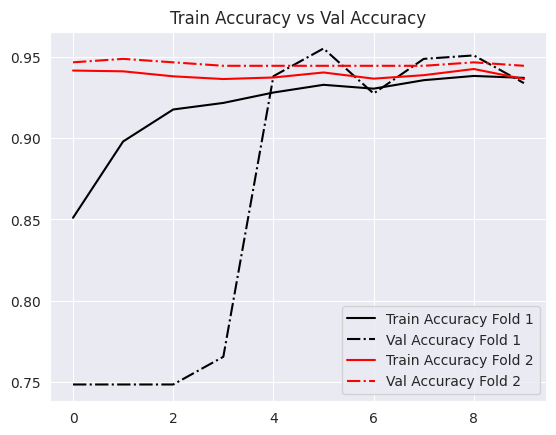

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_9[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_9[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_9[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_9[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_9[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history_9[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

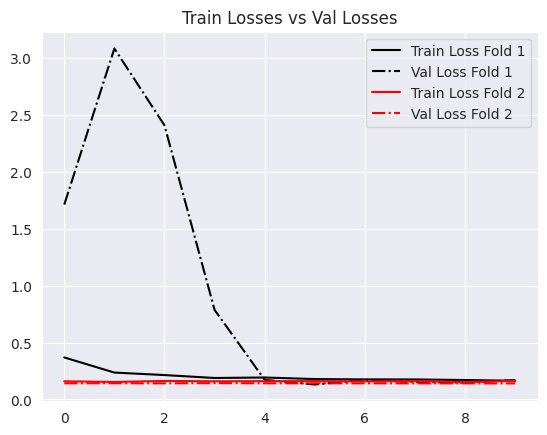

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_9[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_9[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_9[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_9[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_9[2].history['loss'], label='Train Loss Fold 3', color='green', )
#plt.plot(model_history_9[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_9 = load_model('Pneumonia_9.keras')

In [ ]:
print("Loss of the model_9 is - " , model_9.evaluate(X_test, y_test)[0])
print("Accuracy of the model_9 is - " , model_9.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 624ms/step - accuracy: 0.9468 - loss: 0.1522
Loss of the model_9 is -  0.1437283158302307
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 624ms/step - accuracy: 0.9468 - loss: 0.1522
Accuracy of the model_9 is -  94.36860084533691 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_9 = (model_9.predict(X_test) > 0.5).astype("int32")
predictions_9 = predictions_9.reshape(1,-1)[0]
predictions_9[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 631ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_9, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.95      0.96       843
   Normal (Class 1)       0.88      0.92      0.90       329

           accuracy                           0.94      1172
          macro avg       0.93      0.94      0.93      1172
       weighted avg       0.94      0.94      0.94      1172



In [ ]:
cm_9 = confusion_matrix(y_test,predictions_9)
cm_9

array([[802,  41],
       [ 25, 304]])

In [ ]:
cm_9 = pd.DataFrame(cm_9, index = ['0','1'] , columns = ['0','1'])

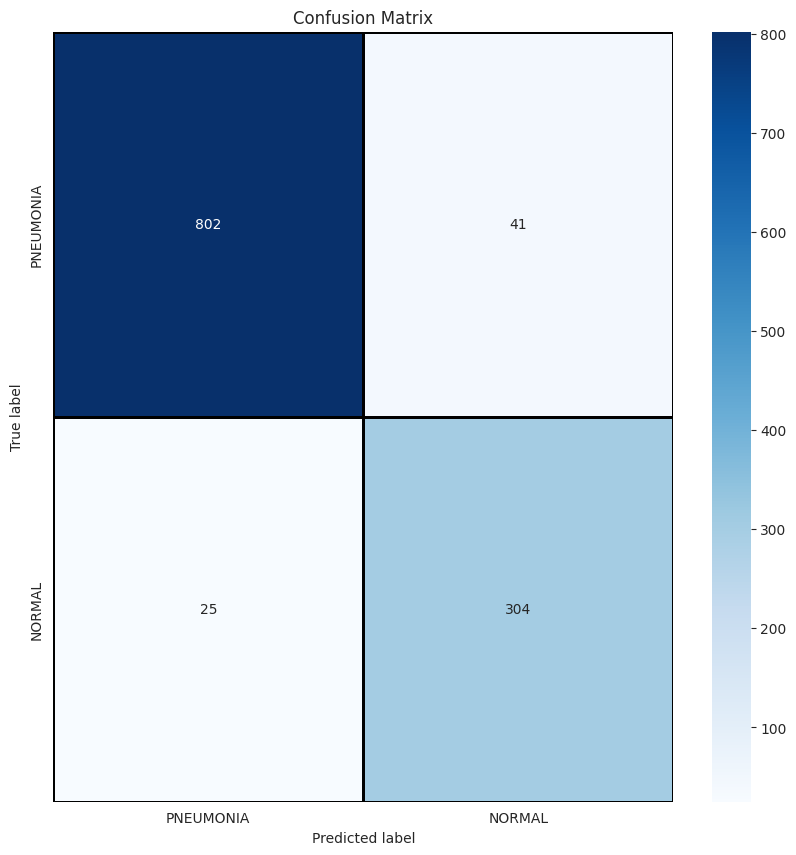

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_9,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_9.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_9 = []
incorrect_9 = []

for i in range(len(predictions_9)):
  if predictions_9[i] == y_test[i]:
    correct_9.append(i)
  else:
    incorrect_9.append(i)

**Display some of the correctly predicted classes**

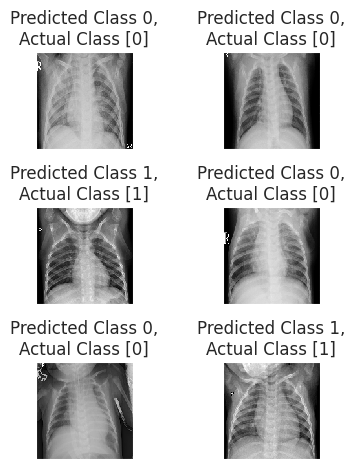

In [ ]:
i = 0
for c in correct_9[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_9[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

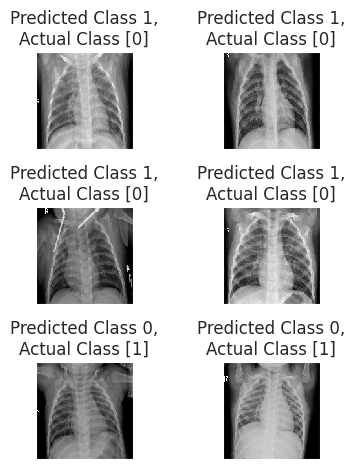

In [ ]:
i = 0
for c in incorrect_9[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_9[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Model 10

1. Implement k-fold cross-validation with hold-out test set.
2. Data augmentation applied to the training data.
3. Sequential CNN.
4. Image size 150X150.
5. **Five convolutional layers** with ReLU activation.
6. Drop-out, batch normalisation and **average pooling** downsampling technique is applied.
7. Optimiser **Adam**.
8. Two fold cross-validation used to validate the model, 10 epochs.
9. Validation dataset is used to tune the hyperparameters and the test dataset is used to obtain the maximum test accuracy.

In [ ]:
model_10 = Sequential()
model_10.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_10.add(BatchNormalization())
model_10.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_10.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_10.add(Dropout(0.1))
model_10.add(BatchNormalization())
model_10.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_10.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_10.add(BatchNormalization())
model_10.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_10.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_10.add(Dropout(0.2))
model_10.add(BatchNormalization())
model_10.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_10.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_10.add(Dropout(0.2))
model_10.add(BatchNormalization())
model_10.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))
model_10.add(Flatten())
model_10.add(Dense(units = 128 , activation = 'relu'))
model_10.add(Dropout(0.2))
model_10.add(Dense(units = 1 , activation = 'sigmoid'))
model_10.compile(optimizer=Adam(learning_rate = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model_10.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 75, 75, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 38, 38, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 19, 19, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 10, 10, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
#fit the model

def fit_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate_reduction, EPOCHS=10, BATCH_SIZE=32):

    model_checkpoint = ModelCheckpoint('Pneumonia_10.keras', verbose=1, save_best_only=True)

    history = model.fit(datagen2.flow(X_train,y_train, batch_size = BATCH_SIZE), validation_data = (X_val, y_val), epochs = EPOCHS, callbacks = [learning_rate_reduction,model_checkpoint])

    print("Val Score: ", model.evaluate(X_val, y_val))
    return history

In [ ]:
# Cross-validation

n_folds = 2

#save the model history in a list after fitting so that we can plot later
model_history_10 = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

    result = fit_and_evaluate(model_10, X_train, y_train, X_val, y_val, learning_rate_reduction)

    model_history_10.append(result)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8293 - loss: 0.3571
Epoch 1: val_loss improved from inf to 0.64382, saving model to Pneumonia_10.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 404s 3s/step - accuracy: 0.8297 - loss: 0.3566 - val_accuracy: 0.7505 - val_loss: 0.6438 - learning_rate: 1.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9140 - loss: 0.2200
Epoch 2: val_loss did not improve from 0.64382
132/132 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.9140 - loss: 0.2199 - val_accuracy: 0.5586 - val_loss: 0.7361 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9195 - loss: 0.2095
Epoch 3: val_loss improved from 0.64382 to 0.35016, saving model to Pneumonia_10.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.9195 - loss: 0.2094 - val_accuracy: 0.8124 - val_loss: 0.3502 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9200 - loss: 0.1997
Epoch 4: val_los

**Plots to see how the models are performing.**

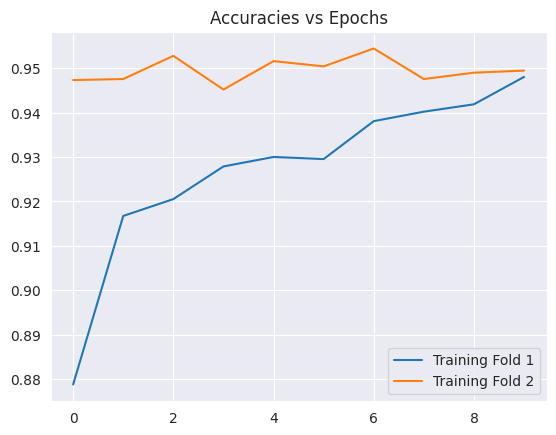

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history_10[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history_10[1].history['accuracy'], label='Training Fold 2')
#plt.plot(model_history_10[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

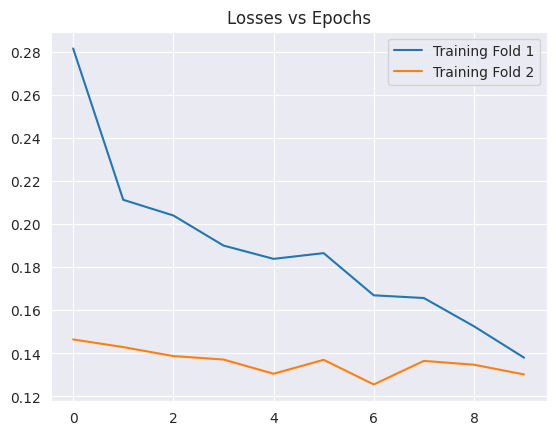

In [ ]:
plt.title('Losses vs Epochs')
plt.plot(model_history_10[0].history['loss'], label='Training Fold 1')
plt.plot(model_history_10[1].history['loss'], label='Training Fold 2')
#plt.plot(model_history_10[2].history['loss'], label='Training Fold 3')
plt.legend()
plt.show()

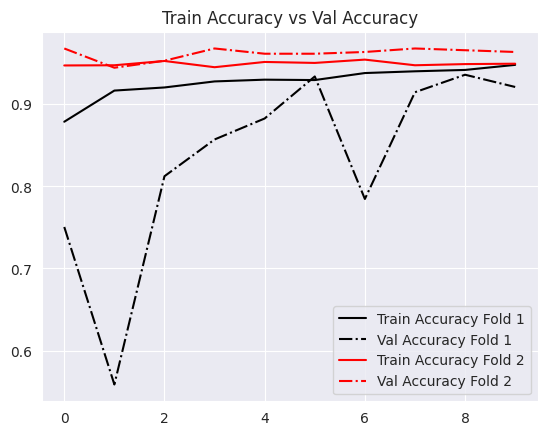

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history_10[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history_10[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_10[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history_10[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_10[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history_10[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

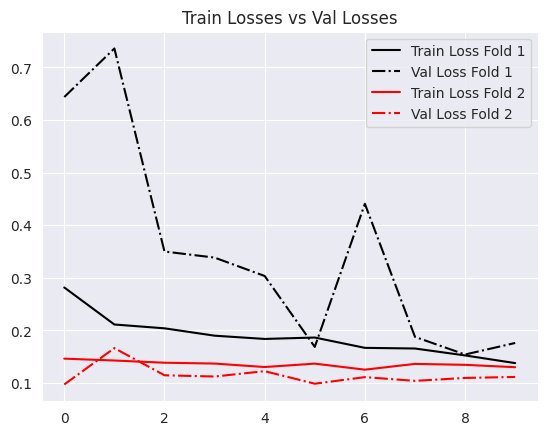

In [ ]:
plt.title('Train Losses vs Val Losses')
plt.plot(model_history_10[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history_10[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history_10[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history_10[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history_10[2].history['loss'], label='Train Loss Fold 3', color='green', )
#plt.plot(model_history_10[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

**Test the score on the test split**

In [ ]:
#Load the model that was saved by ModelCheckpoint

model_10 = load_model('Pneumonia_10.keras')

In [ ]:
print("Loss of the model_10 is - " , model_10.evaluate(X_test, y_test)[0])
print("Accuracy of the model_10 is - " , model_10.evaluate(X_test,y_test)[1]*100 , "%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 641ms/step - accuracy: 0.9508 - loss: 0.1289
Loss of the model_10 is -  0.12491127103567123
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 576ms/step - accuracy: 0.9508 - loss: 0.1289
Accuracy of the model_10 is -  95.13651728630066 %


**Calculate performance metrics and confusion matrix.**

In [ ]:
X_test.shape

(1172, 150, 150, 1)

In [ ]:
# Make predictions on the unseen test dataset

predictions_10 = (model_10.predict(X_test) > 0.5).astype("int32")
predictions_10 = predictions_10.reshape(1,-1)[0]
predictions_10[:15]

37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 582ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions_10, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.97      0.97       843
   Normal (Class 1)       0.92      0.91      0.91       329

           accuracy                           0.95      1172
          macro avg       0.94      0.94      0.94      1172
       weighted avg       0.95      0.95      0.95      1172



In [ ]:
cm_10 = confusion_matrix(y_test,predictions_10)
cm_10

array([[817,  26],
       [ 31, 298]])

In [ ]:
cm_10 = pd.DataFrame(cm_10, index = ['0','1'] , columns = ['0','1'])

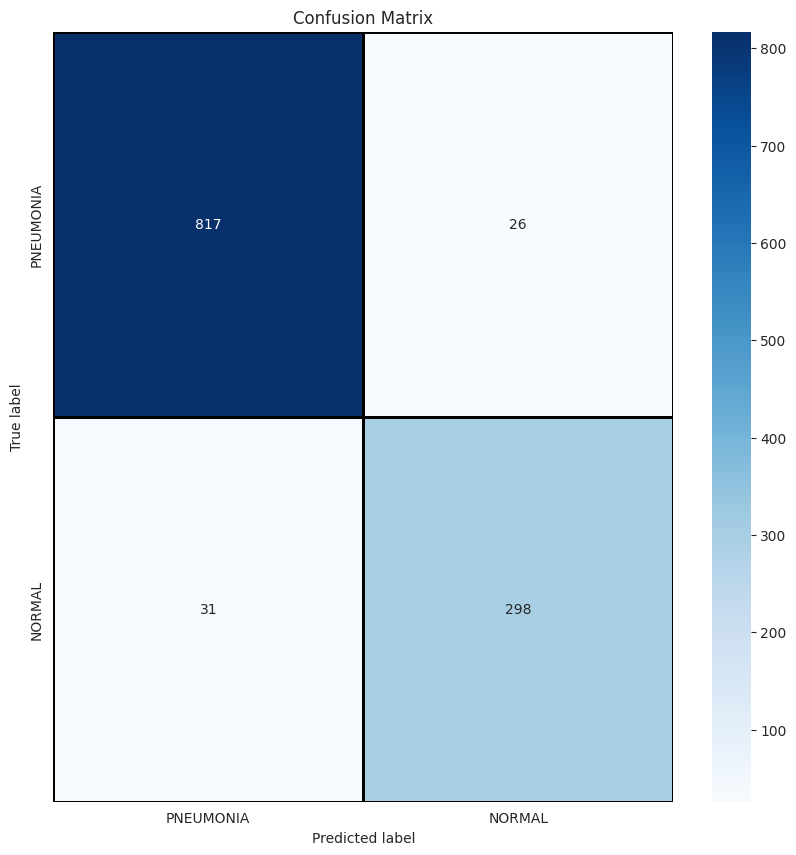

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_10,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# Get the current axes object
ax = plt.gca()
# Label the axes
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticklabels=labels,
         yticklabels=labels)
plt.show()

**Make predictions**

In [ ]:
predictions_10.shape

(1172,)

In [ ]:
y_test.shape

(1172, 1)

In [ ]:
correct_10 = []
incorrect_10 = []

for i in range(len(predictions_10)):
  if predictions_10[i] == y_test[i]:
    correct_10.append(i)
  else:
    incorrect_10.append(i)

**Display some of the correctly predicted classes**

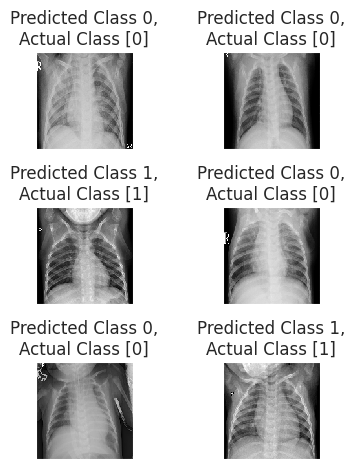

In [ ]:
i = 0
for c in correct_10[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_10[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Display some of the incorrectly predicted classes**

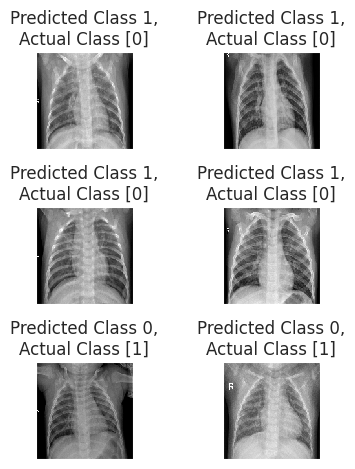

In [ ]:
i = 0
for c in incorrect_10[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(predictions_10[c], y_test[c]))
    plt.tight_layout()
    i += 1